#### Libraries

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg
import numpy as np
from numpy import expand_dims
import argparse
import os
import glob
import xmltodict
import xml.etree.ElementTree as ET
import xml.etree.ElementTree as ET # copy of xml
from xml.etree.ElementTree import parse
import cv2
from skimage import io
from scipy.signal import convolve2d
from PIL import Image  
import PIL 
import urllib
from urllib.request import urlopen
from typing import Tuple, List, Dict
from bs4 import BeautifulSoup
import requests
from io import BytesIO
from keras.applications import MobileNetV2
from keras import layers
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras import models
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
# from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.preprocessing.image import array_to_img
# from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator # load the image
from keras.utils.image_utils import load_img
from keras.utils.image_utils import img_to_array
from keras.utils import to_categorical
from keras import backend as K
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report
import seaborn as sns 

##### Warnings #####

In [7]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

## Data preprocessing

#### URLs for images and annotations

In [8]:
prefix_url_imgs = "https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/images/"
number_of_imgs = 766 # +1 to include last one (765)

list_imgs = []

for i in range(0, number_of_imgs):
    i = str(i)
    var_imgs = "BikesHelmets" + i + ".png"
    var_imgs_url = prefix_url_imgs + var_imgs
    list_imgs.append(var_imgs_url)

In [9]:
prefix_url_xml = "https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/annotations/"
number_of_annt = 766 # +1 to include last one (765)

list_annotations= []

for i in range(0, number_of_annt):
    i = str(i)
    var_annt = "BikesHelmets" + i + ".xml"
    var_annt_url = prefix_url_xml + var_annt
    list_annotations.append(var_annt_url)

### Augmentantion functions

In [10]:
def picture_zoom(image):
   # to array
   array = expand_dims(image[1], 0)
   # create image data augmentation generator
   datagen_zoom= ImageDataGenerator(zoom_range=[0.8,1.5])
   # prepare iterator
   it_zoom = datagen_zoom.flow(array, batch_size=1)
   # generate batch of images
   batch_zoom = it_zoom.next()
   # convert to unsigned integers for viewing
   image_zoom = batch_zoom[0].astype('uint64')
   # returning list
   list = [image[0], image_zoom, image[2], image[3]]
   return list

In [11]:
def picture_rotation(image):
    # to array
    array = expand_dims(image[1], 0)
    # ImageDataGenerator rotation
    datagen_rotation=ImageDataGenerator(rotation_range=45, fill_mode='nearest')
    # prepare iterator
    it_rotation = datagen_rotation.flow(array, batch_size=1)
    # generate batch of images
    batch_rotation = it_rotation.next()
    # convert to unsigned integers for viewing
    image_rotation = batch_rotation[0].astype('uint64')
    # plot raw pixel 
    img_rotation=plt.imshow(image_rotation, interpolation ='None', filternorm=True) #spline36, antialiased
    # returning list
    list = [image[0], image_rotation, image[2], image[3]]
    return list

In [12]:
def picture_brightness(image):
    # to array
    array = expand_dims(image[1], 0)
    # create image data augmentation generator
    datagen_brightness = ImageDataGenerator(brightness_range=[0.2,1.0])
    # prepare iterator
    it_brightness = datagen_brightness.flow(array, batch_size=1)
    # generate batch of images
    batch_zoom = it_brightness.next()
    # convert to unsigned integers for viewing
    image_brightness = batch_zoom[0].astype('uint64')
    # plot raw pixel 
    img_brightness=plt.imshow(image_brightness, interpolation ='None')
    # returning list
    list = [image[0], image_brightness, image[2], image[3]]
    return list

### Images load
* Retrieving and labelling images from XML annotations
* No bounding box, multiple faces per image
* For images with multiple people, if and only if all people wear helmet the label would be 1, otherwise label would be 0.

In [13]:
full_imgs = []

for xml_path in list_annotations:
    try:    
        with urlopen(xml_path) as my_xml:
        
            xmld = xmltodict.parse(my_xml)
            tags = xmld['annotation']

            a = 0
            img_path = prefix_url_imgs + tags['filename']
            img_url = requests.get(img_path)
            img_temp = Image.open(BytesIO(img_url.content))
            resized = img_temp.resize((224,224)) # resize all images to 224x224
            image = cv2.cvtColor(np.array(resized), cv2.INPAINT_TELEA)
            
            if 'object' in tags:

                if isinstance(tags['object'], list):
                    for i in tags['object']:
                        if i['name'] == 'With Helmet':
                            a =+1
                        else:
                            a =+0
                    if a > 0 :
                        full_imgs.append([tags['filename'], image, 1, img_path])
                    else :
                        full_imgs.append([tags['filename'], image, 0, img_path])
                
                if isinstance(tags['object'], dict):
                    if tags['object']['name'] == 'With Helmet':
                        full_imgs.append([tags['filename'], image, 1, img_path])
                    else:
                        full_imgs.append([tags['filename'], image, 0, img_path])
            else:
                pass
    except:
        pass

* Augment full images

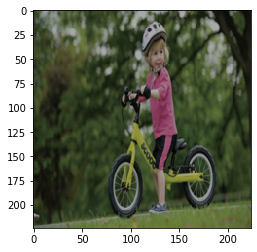

In [14]:
# Augmentantion of full images
augm_full_imgs = []
for i in range(0, len(full_imgs)):
    augm_full_imgs.append(picture_zoom(full_imgs[i]))
    augm_full_imgs.append(picture_rotation(full_imgs[i]))
    augm_full_imgs.append(picture_brightness(full_imgs[i]))

In [15]:
# consolidate initial with augmented images in one list
final_full_imgs = full_imgs + augm_full_imgs

print("Total full images:", len(final_full_imgs))
print("of which initial images:", len(full_imgs))
print("of which augmented images:", len(augm_full_imgs))

Total full images: 3044
of which initial images: 761
of which augmented images: 2283


Text(0, 0.5, 'Labels')

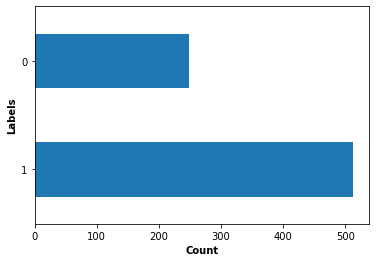

In [16]:
# Converts lists for images names and for the corresponding label names
list1=[]
list2=[]

for i in range(0,len(full_imgs)):
    list1.append(full_imgs[i][0])
    list2.append(full_imgs[i][2])
    
df=pd.DataFrame()
df=df.assign(Images=list1)
df=df.assign(Labels=list2)

df["Labels"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Labels', fontsize = 10, fontweight = 'bold')

* Transform full images to model inputs

In [17]:
# Transforming images in a proper array for model input
full_imgs_array = []
for i in range(0, len(final_full_imgs)):
    full_imgs_array.append(np.array(final_full_imgs[i][1]))
full_imgs_array = np.array(full_imgs_array, dtype='int')

In [18]:
# shape of new array
full_imgs_array.shape

(3044, 224, 224, 3)

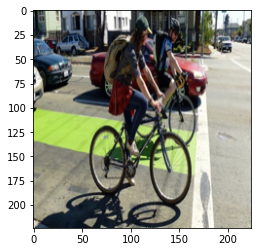

In [19]:
# testing that images appear correctly
plt.imshow(full_imgs_array[714])

In [20]:
#In Model2 does not need the reshape

# # reshape of array
# full_imgs_array_rshp = full_imgs_array.reshape(len(final_full_imgs), 224*224*3)

In [21]:
#In Model2 does not need the reshape

# # testing that images appear correctly
# plt.imshow(full_imgs_array_rshp[1500].reshape(224, 224, 3))

In [22]:
#In Model2 does not need the reshape

# # normalize colors
# full_imgs_array_final = full_imgs_array_rshp.astype('float32') / 255

In [23]:
#In Model2 does not need the reshape

# # final shape of input array
# full_imgs_array_final.shape

In [24]:
# Creating an array with labels
labels_array = []
for i in range(0, len(final_full_imgs)):
    labels_array.append(np.array(final_full_imgs[i][2]))
labels_array = np.array(labels_array, dtype='int')

In [25]:
# Categorically encode the labels
full_imgs_labels = to_categorical(labels_array)

### Data reshaping

In [30]:
def reshape_img_input(x: np.ndarray,
                      img_rows: int = 224,
                      img_cols: int = 224,
                      normalize: bool = True) -> Tuple:
    """
    This function reshapes a n-dimensional numpy array of images into another format.
    Also normalizes the images
    
    :param x: N-dimensional array containing images
    :param img_rows: The output width of each of the images
    :param img_cols: The output height of each of the images
    :param normalize: Whether to normalize the images or not
    :return: A numpy array with the transformed images and the shape of each observation (image)
    """
    
    print(f'Original shape of nd-array: {x.shape}')
    
    if K.image_data_format() == 'channels_first':
        
        # the channel dimension goes to the front
        x1 = x.reshape(x.shape[0], 3, img_rows, img_cols)

        input_shape = (3, img_rows, img_cols)

    else:
        # the channel dimension goes to the end. So we end up with the following 4-D tensor
        # (N-samples, Height, Width, N-channels)
        x1 = x.reshape(x.shape[0], img_rows, img_cols, 3)

        input_shape = (img_rows, img_cols, 3)

    x1 = x1.astype('float32')

    if normalize:
        x1 /= 255.
    
    
    return x1, input_shape

In [31]:
data, input_shape = reshape_img_input(x=full_imgs_array,
                                         img_rows=224, 
                                         img_cols=224,
                                         normalize=True)

Original shape of nd-array: (3044, 224, 224, 3)


### Train, Test & Validation split
* We now split the full dataset into train (75%) and test (25%) sets. 
* The test set is splitted again to test (25%) and validation (75%) sets.
* Random sampling is a very bad option for splitting. So, we tried stratified sampling. 
* This method splits your class proportionally between training and test set. Run oversampling, undersampling or hybrid techniques on training set.

In [32]:
#https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# split into train test sets
from sklearn.model_selection import train_test_split
X_train, X_test_1, y_train, y_test_1 = train_test_split(data, full_imgs_labels,
                                                    stratify=full_imgs_labels, 
                                                    test_size=0.25, random_state=5)

X_test, X_val, y_test, y_val = train_test_split(X_test_1, y_test_1,
                                                    stratify=y_test_1, 
                                                    test_size=0.25, random_state=5)

## Models hyperparameters

#### Universal parameters
* Setting parameters to be used across models.

In [159]:
learning_Rate = 1e-3
num_Epochs = 50
batch_Size = 32
steps_per_Epoch = int(len(X_train) / batch_size)

### Callbacks

#### Early Stopping
* Before training the network, we define an early stopping criterion, to avoid redundent epochs once the model has already converged.

In [163]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 8, verbose = 1, restore_best_weights = True)

#### Reduce Learning Rate On Plateau
* We define a ReduceLROnPlateau callback to reduce the learning rate when the metric we chose (val_loss) has stopped improving.

In [151]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.1, min_lr = 1e-6)

## Models

### Model 1 (Simple Model)
* https://github.com/mohandandamudi/FaceMaskDetection/blob/master/Face%20Mask%20Detection.ipynb

In [138]:
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.models import Sequential
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

* Buliding Model 

In [160]:
# Adding model layers
model_few_Layers = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(2, activation='softmax')
])
model_few_Layers.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 394272)            0         
                                                                 
 dense_16 (Dense)            (None, 2)                 788546    
                                                                 
Total params: 789,442
Trainable params: 789,442
Non-trainable params: 0
_________________________________________________________________


* Compiling Model

In [ ]:
opt = optimizers.Adam(learning_rate=learning_Rate) 
model_few_Layers.compile(optimizer=opt, 
                         loss='categorical_crossentropy', 
                         metrics=['accuracy', 'Recall', 'Precision', 'AUC']) #categorical_crossentropy or binary_crossentropy

* Fitting Model

In [162]:
model_1 = model_few_Layers.fit(
                    x = X_train,
                    y = y_train,
                    epochs = num_Epochs, #>=30 / early stopping epoch: 10
                    steps_per_epoch = steps_per_Epoch, 
                    batch_size = batch_Size, 
                    verbose = 1,
                    validation_data = (X_val,y_val),
                    callbacks = [early_stopping, lrr]
                    )

Epoch 1/50
71/71 [==============================] - 34s 462ms/step - loss: 2.6680 - accuracy: 0.6100 - recall: 0.6100 - precision: 0.6100 - auc: 0.6216 - val_loss: 0.5617 - val_accuracy: 0.7382 - val_recall: 0.7382 - val_precision: 0.7382 - val_auc: 0.7961 - lr: 0.0010
Epoch 2/50
71/71 [==============================] - 33s 466ms/step - loss: 0.4156 - accuracy: 0.8223 - recall: 0.8223 - precision: 0.8223 - auc: 0.9004 - val_loss: 0.4593 - val_accuracy: 0.8063 - val_recall: 0.8063 - val_precision: 0.8063 - val_auc: 0.8730 - lr: 0.0010
Epoch 3/50
71/71 [==============================] - 32s 445ms/step - loss: 0.1917 - accuracy: 0.9445 - recall: 0.9445 - precision: 0.9445 - auc: 0.9853 - val_loss: 0.4379 - val_accuracy: 0.7853 - val_recall: 0.7853 - val_precision: 0.7853 - val_auc: 0.8779 - lr: 0.0010
Epoch 4/50
71/71 [==============================] - 31s 437ms/step - loss: 0.0973 - accuracy: 0.9805 - recall: 0.9805 - precision: 0.9805 - auc: 0.9947 - val_loss: 0.4594 - val_accuracy: 0.8

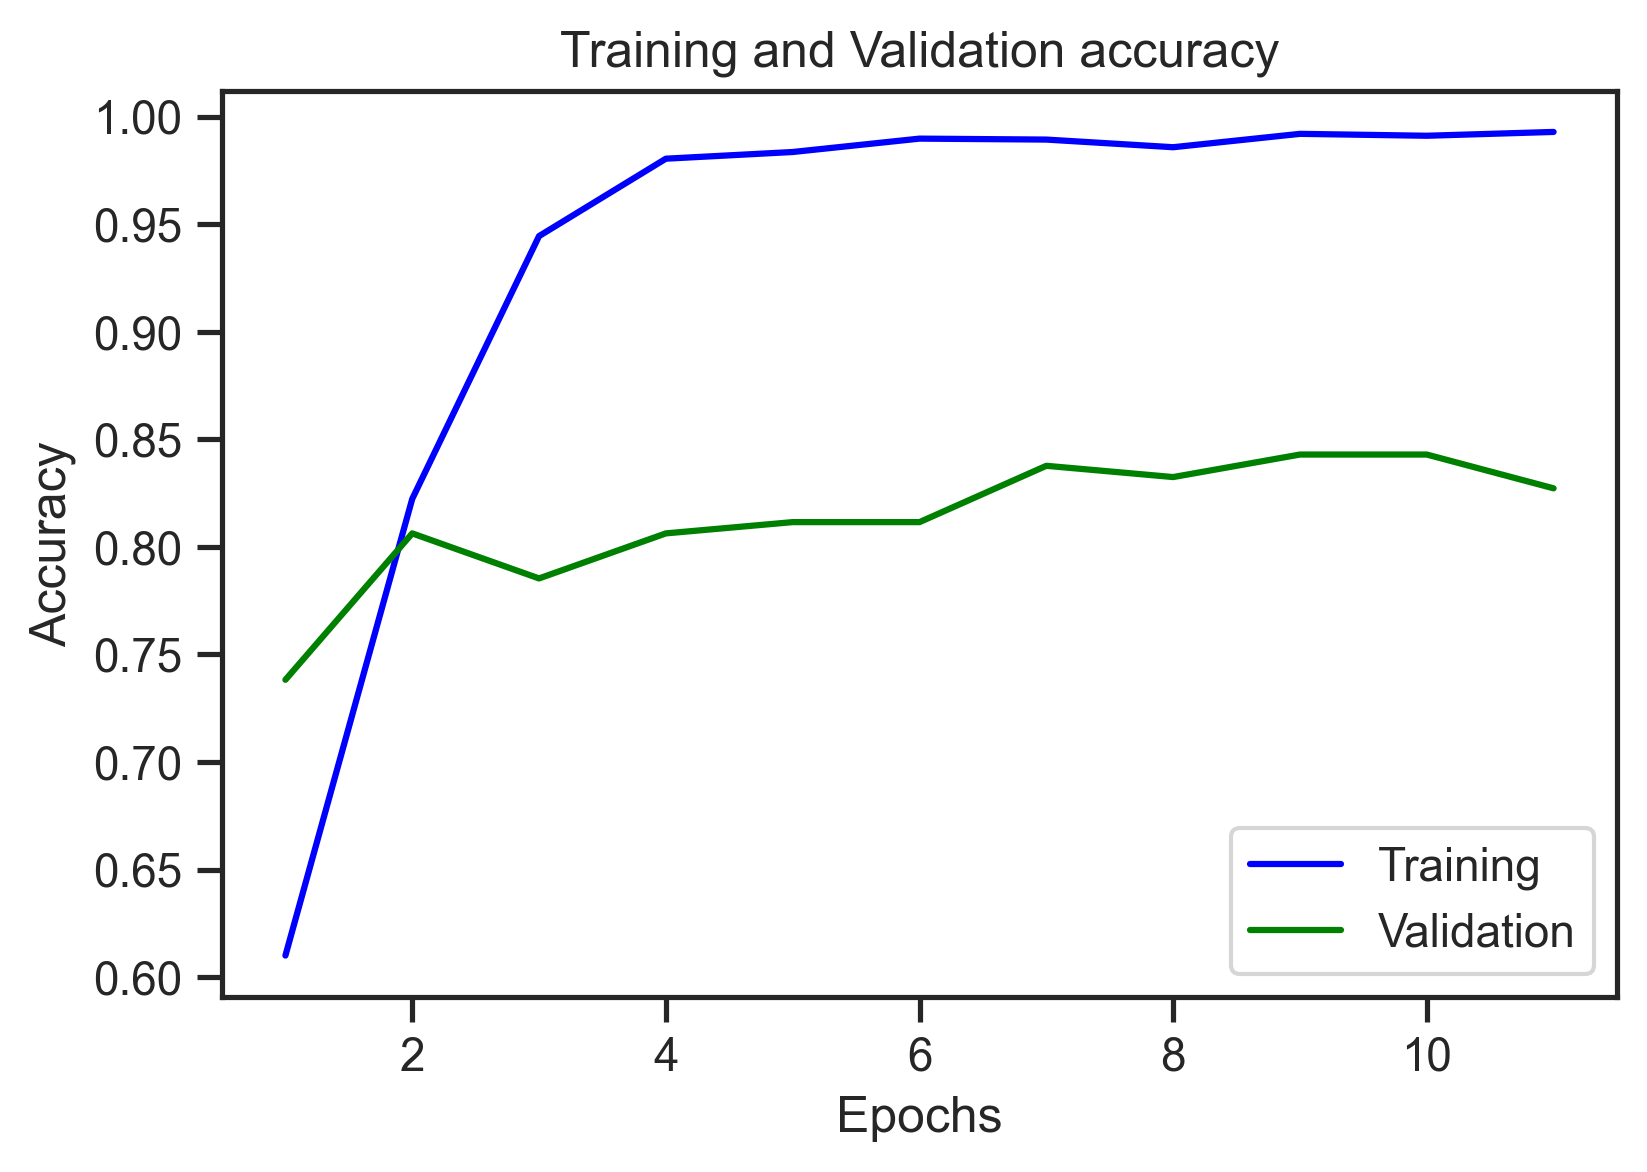

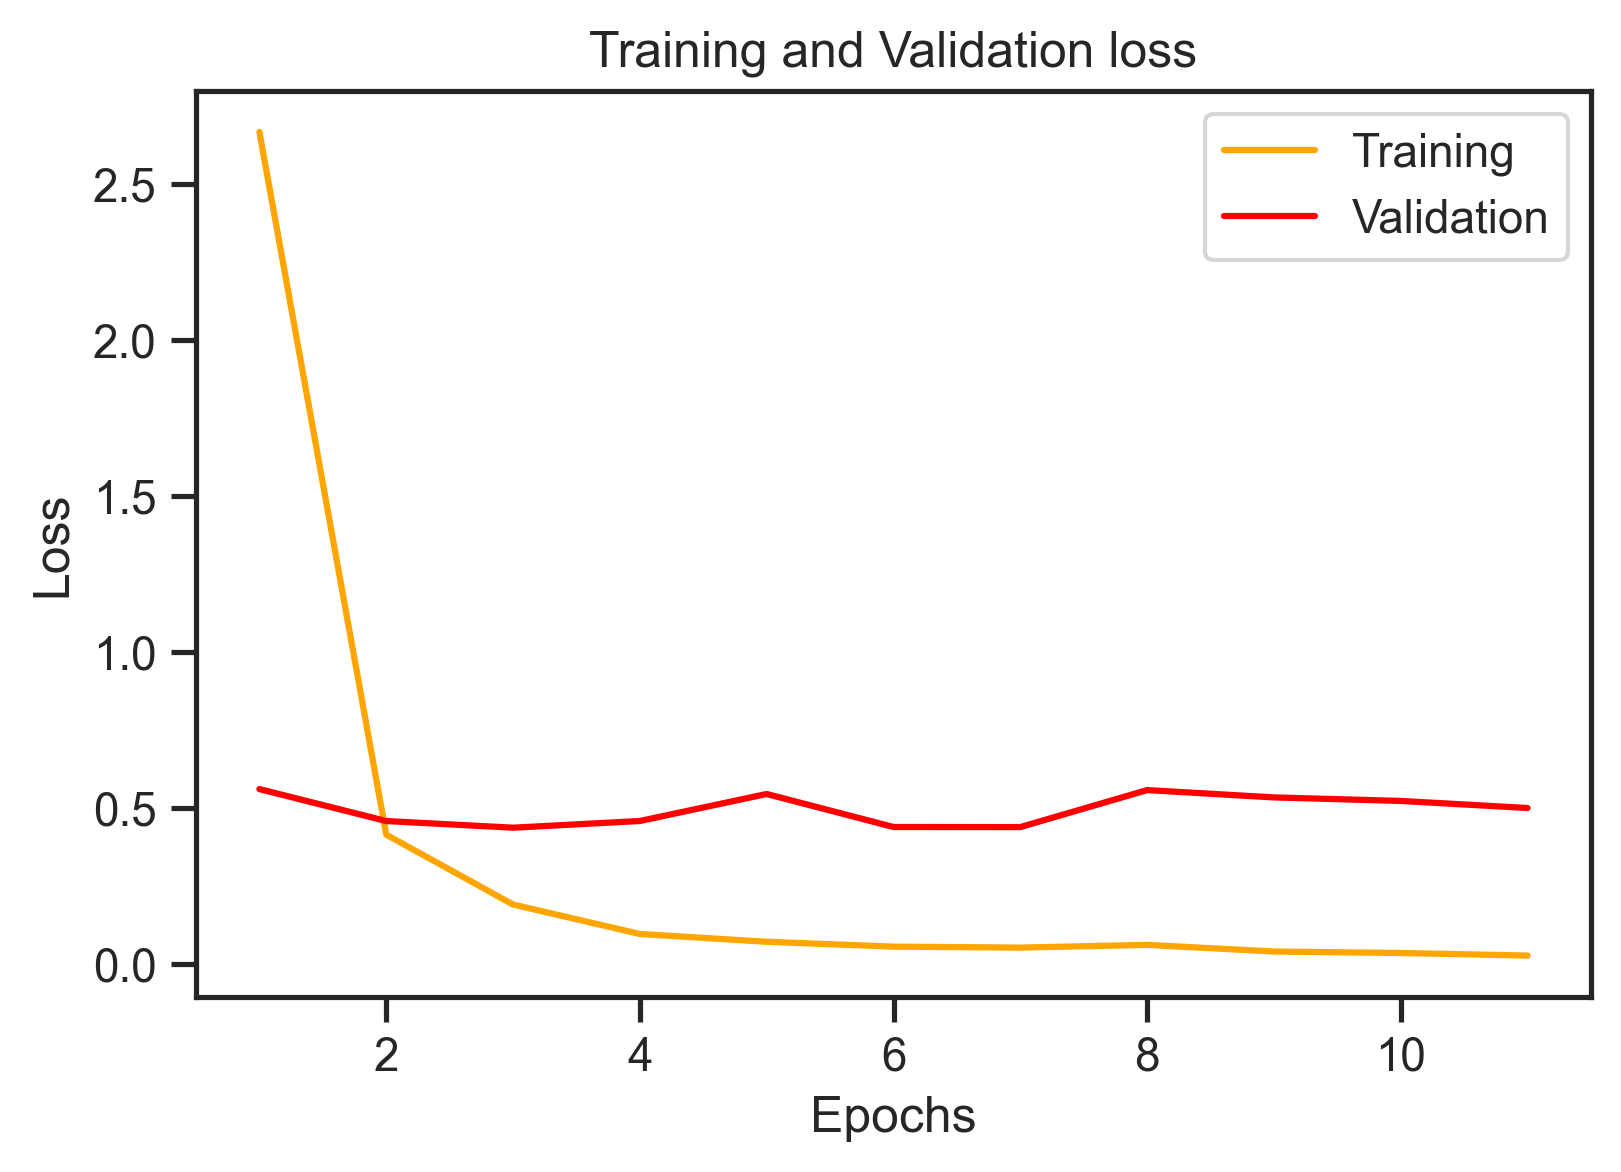

In [164]:
loss = model_1.history['loss']
val_loss = model_1.history['val_loss']
acc = model_1.history['accuracy']
val_acc = model_1.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 2 - Base CNN

* Building Model

In [166]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_complex = Sequential()
model_complex.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (224, 224, 3)))
model_complex.add(MaxPooling2D(pool_size = 2))
model_complex.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model_complex.add(MaxPooling2D(pool_size = 2))
model_complex.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model_complex.add(MaxPooling2D(pool_size = 2))
model_complex.add(Dropout(0.3))
model_complex.add(Flatten())
model_complex.add(Dense(units = 500, activation = 'relu'))
model_complex.add(Dropout(0.4)) #model_complex.add(Dropout(0.3))
model_complex.add(Dense(units = 2, activation = 'softmax')) #Check if the last Dense Layer(output) has same number of classes as the number of target classes in the training dataset.
model_complex.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 28, 28, 64)     

* Compliling Model

In [ ]:
model_complex.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

* Fitting Model

In [169]:
model_2 = model_complex.fit(
                    x = X_train,
                    y = y_train,
                    epochs = num_Epochs, #>=30 / Early stopping: 15 epochs
                    steps_per_epoch = steps_per_Epoch, 
                    batch_size = batch_Size,
                    verbose = 1,
                    validation_data = (X_val, y_val),
                    callbacks = [early_stopping, lrr]
                    )

Epoch 1/50
71/71 [==============================] - 56s 769ms/step - loss: 0.9075 - accuracy: 0.6558 - recall: 0.6558 - precision: 0.6558 - auc: 0.6548 - val_loss: 0.6625 - val_accuracy: 0.6754 - val_recall: 0.6754 - val_precision: 0.6754 - val_auc: 0.6576 - lr: 0.0010
Epoch 2/50
71/71 [==============================] - 53s 754ms/step - loss: 0.6128 - accuracy: 0.6881 - recall: 0.6881 - precision: 0.6881 - auc: 0.7256 - val_loss: 0.5695 - val_accuracy: 0.7068 - val_recall: 0.7068 - val_precision: 0.7068 - val_auc: 0.7925 - lr: 0.0010
Epoch 3/50
71/71 [==============================] - 55s 775ms/step - loss: 0.5372 - accuracy: 0.7201 - recall: 0.7201 - precision: 0.7201 - auc: 0.8074 - val_loss: 0.6448 - val_accuracy: 0.6859 - val_recall: 0.6859 - val_precision: 0.6859 - val_auc: 0.7494 - lr: 0.0010
Epoch 4/50
71/71 [==============================] - 54s 762ms/step - loss: 0.4455 - accuracy: 0.7885 - recall: 0.7885 - precision: 0.7885 - auc: 0.8753 - val_loss: 0.5012 - val_accuracy: 0.7

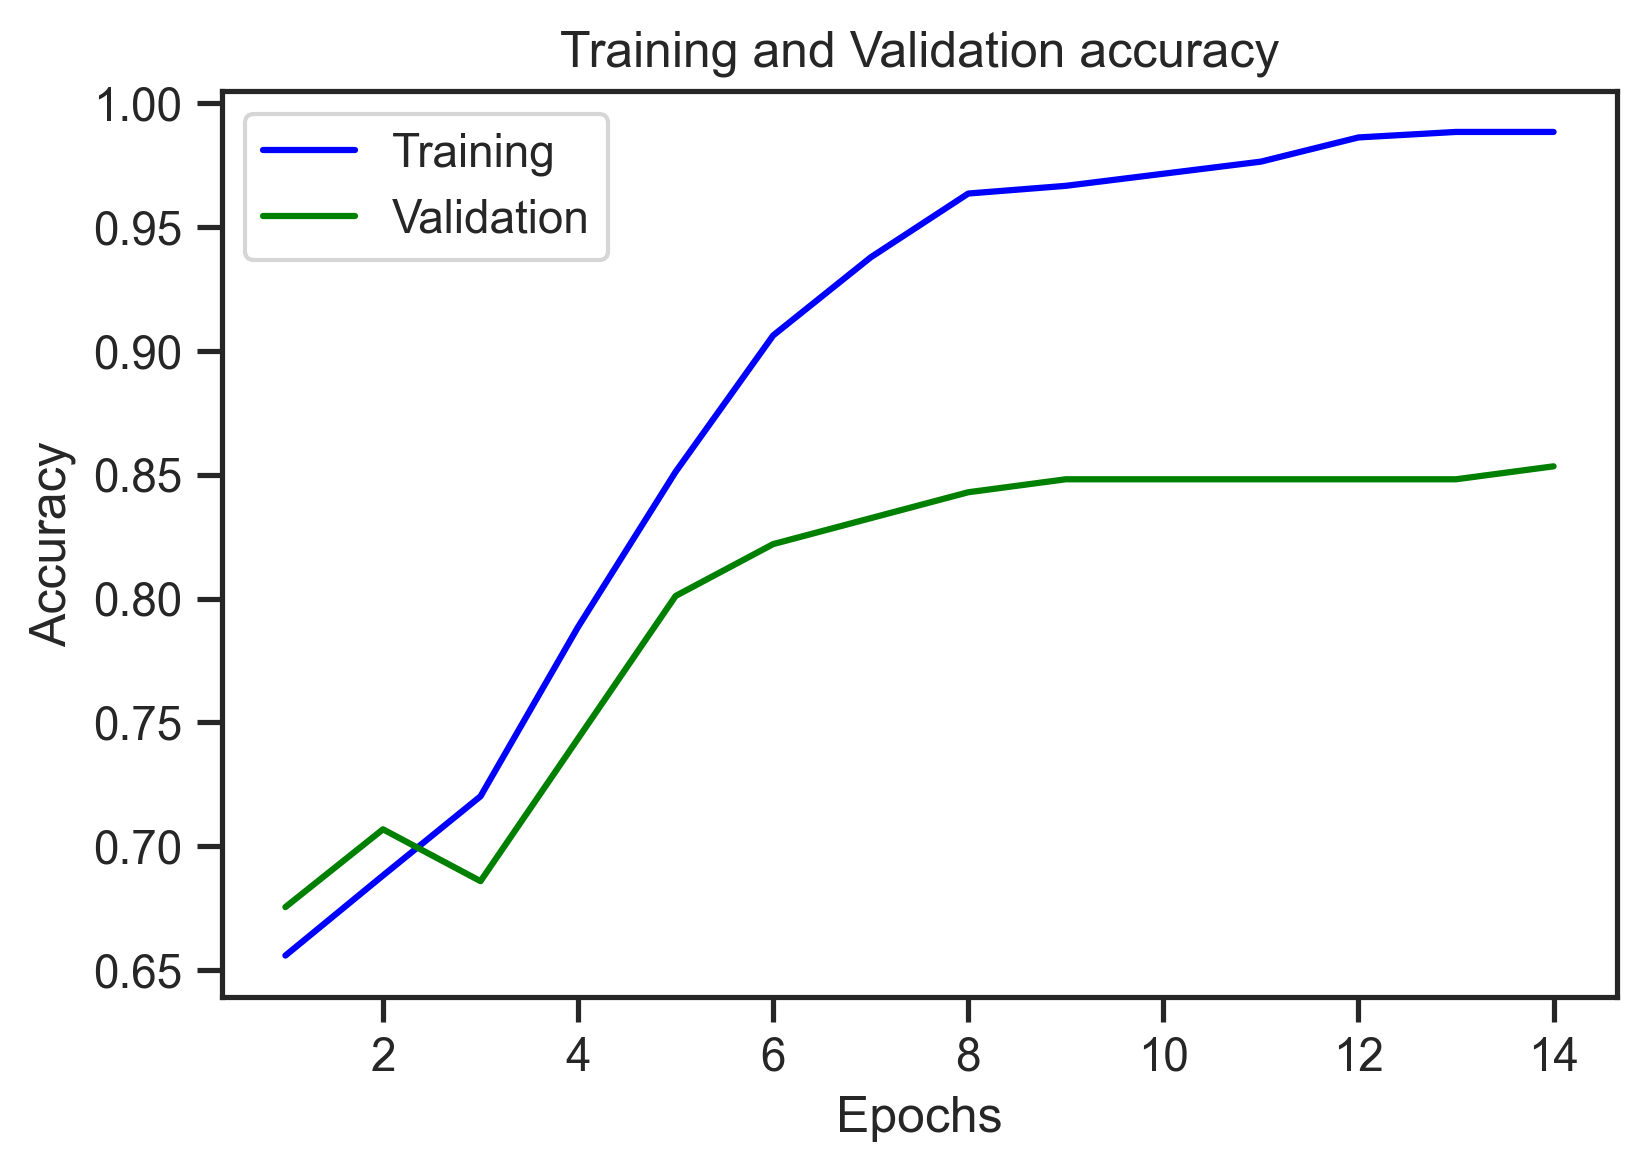

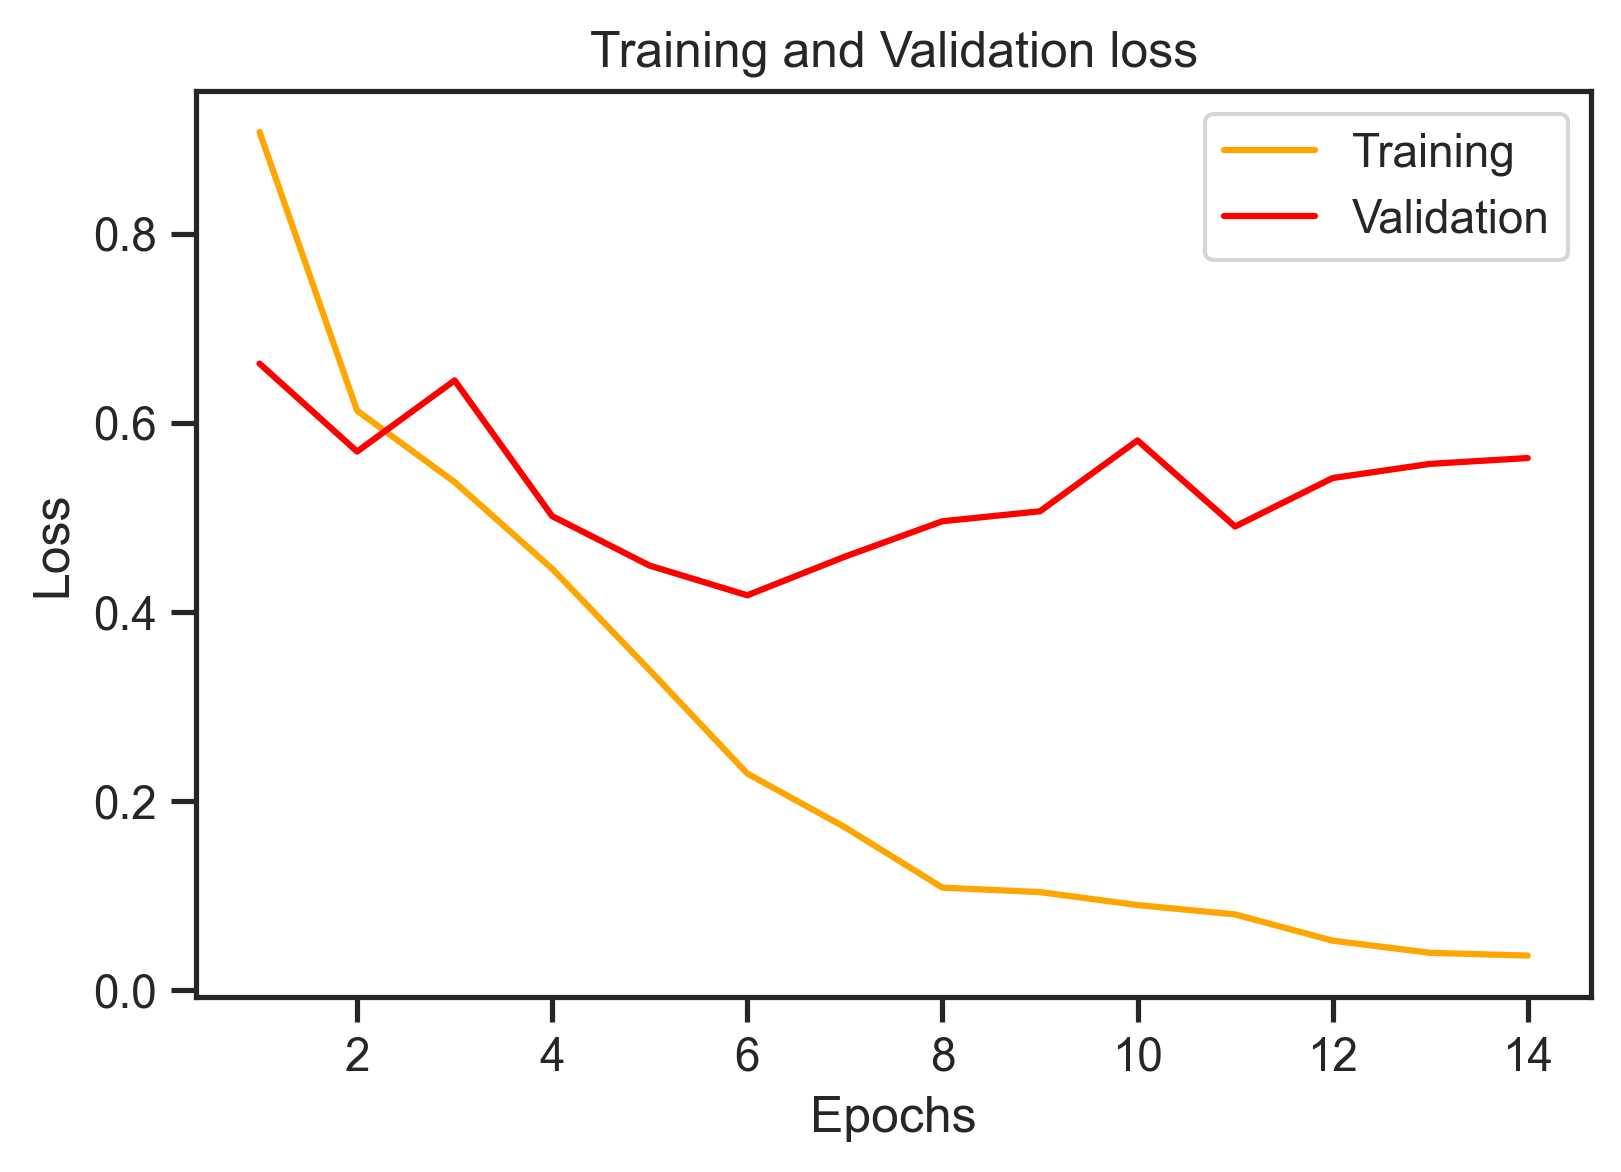

In [170]:
loss = model_2.history['loss']
val_loss = model_2.history['val_loss']
acc = model_2.history['accuracy']
val_acc = model_2.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 2.5 - Adjusted Base CNN (Gogos)

In [179]:
# placeholder for comments regarding differences with model 2

In [171]:
#Model CNN with RmsProp Optimizer
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten,Dense,Dropout

* Model Building

In [176]:
model_complex_adj=Sequential()
model_complex_adj.add(Conv2D(filters = 16, kernel_size = 3, padding='same', activation = 'relu', input_shape = (224, 224, 3)))
model_complex_adj.add(MaxPooling2D(pool_size = 2))
model_complex_adj.add(Conv2D(filters = 32, kernel_size=3,padding='same', activation='relu'))
model_complex_adj.add(MaxPooling2D(pool_size = 2))
model_complex_adj.add(Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu'))
model_complex_adj.add(MaxPooling2D(pool_size = 2))
model_complex_adj.add(Conv2D(filters = 128, kernel_size = 3, padding='same', activation = 'relu'))
model_complex_adj.add(MaxPooling2D(pool_size = 2))
model_complex_adj.add(Flatten())
model_complex_adj.add(Dense(units = 500, activation = 'relu'))
model_complex_adj.add(Dropout(0.3))
model_complex_adj.add(Dense(units = 50, activation = 'relu'))
model_complex_adj.add(Dense(units = 2, activation ='softmax'))
model_complex_adj.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 28, 28, 64)     

* Compiling Model

In [177]:
model_complex_adj.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

* Fitting Model

In [178]:
model_2_5 = model_complex_adj.fit(
                    x = X_train,
                    y = y_train,
                    steps_per_epoch = steps_per_Epoch,
                    epochs = num_Epochs,
                    batch_size = batch_Size,
                    verbose = 1, 
                    shuffle = True,
                    validation_data = (X_val, y_val),
                    callbacks = [early_stopping, lrr]
                )

Epoch 1/50
71/71 [==============================] - 61s 844ms/step - loss: 0.6902 - accuracy: 0.6598 - recall: 0.6598 - precision: 0.6598 - auc: 0.6747 - val_loss: 0.6245 - val_accuracy: 0.6754 - val_recall: 0.6754 - val_precision: 0.6754 - val_auc: 0.6945 - lr: 0.0010
Epoch 2/50
71/71 [==============================] - 57s 810ms/step - loss: 0.6223 - accuracy: 0.6761 - recall: 0.6761 - precision: 0.6761 - auc: 0.7179 - val_loss: 0.6297 - val_accuracy: 0.6806 - val_recall: 0.6806 - val_precision: 0.6806 - val_auc: 0.7375 - lr: 0.0010
Epoch 3/50
71/71 [==============================] - 57s 798ms/step - loss: 0.5934 - accuracy: 0.6890 - recall: 0.6890 - precision: 0.6890 - auc: 0.7533 - val_loss: 0.5921 - val_accuracy: 0.6806 - val_recall: 0.6806 - val_precision: 0.6806 - val_auc: 0.7576 - lr: 0.0010
Epoch 4/50
71/71 [==============================] - 57s 797ms/step - loss: 0.5374 - accuracy: 0.7357 - recall: 0.7357 - precision: 0.7357 - auc: 0.8038 - val_loss: 0.5157 - val_accuracy: 0.7

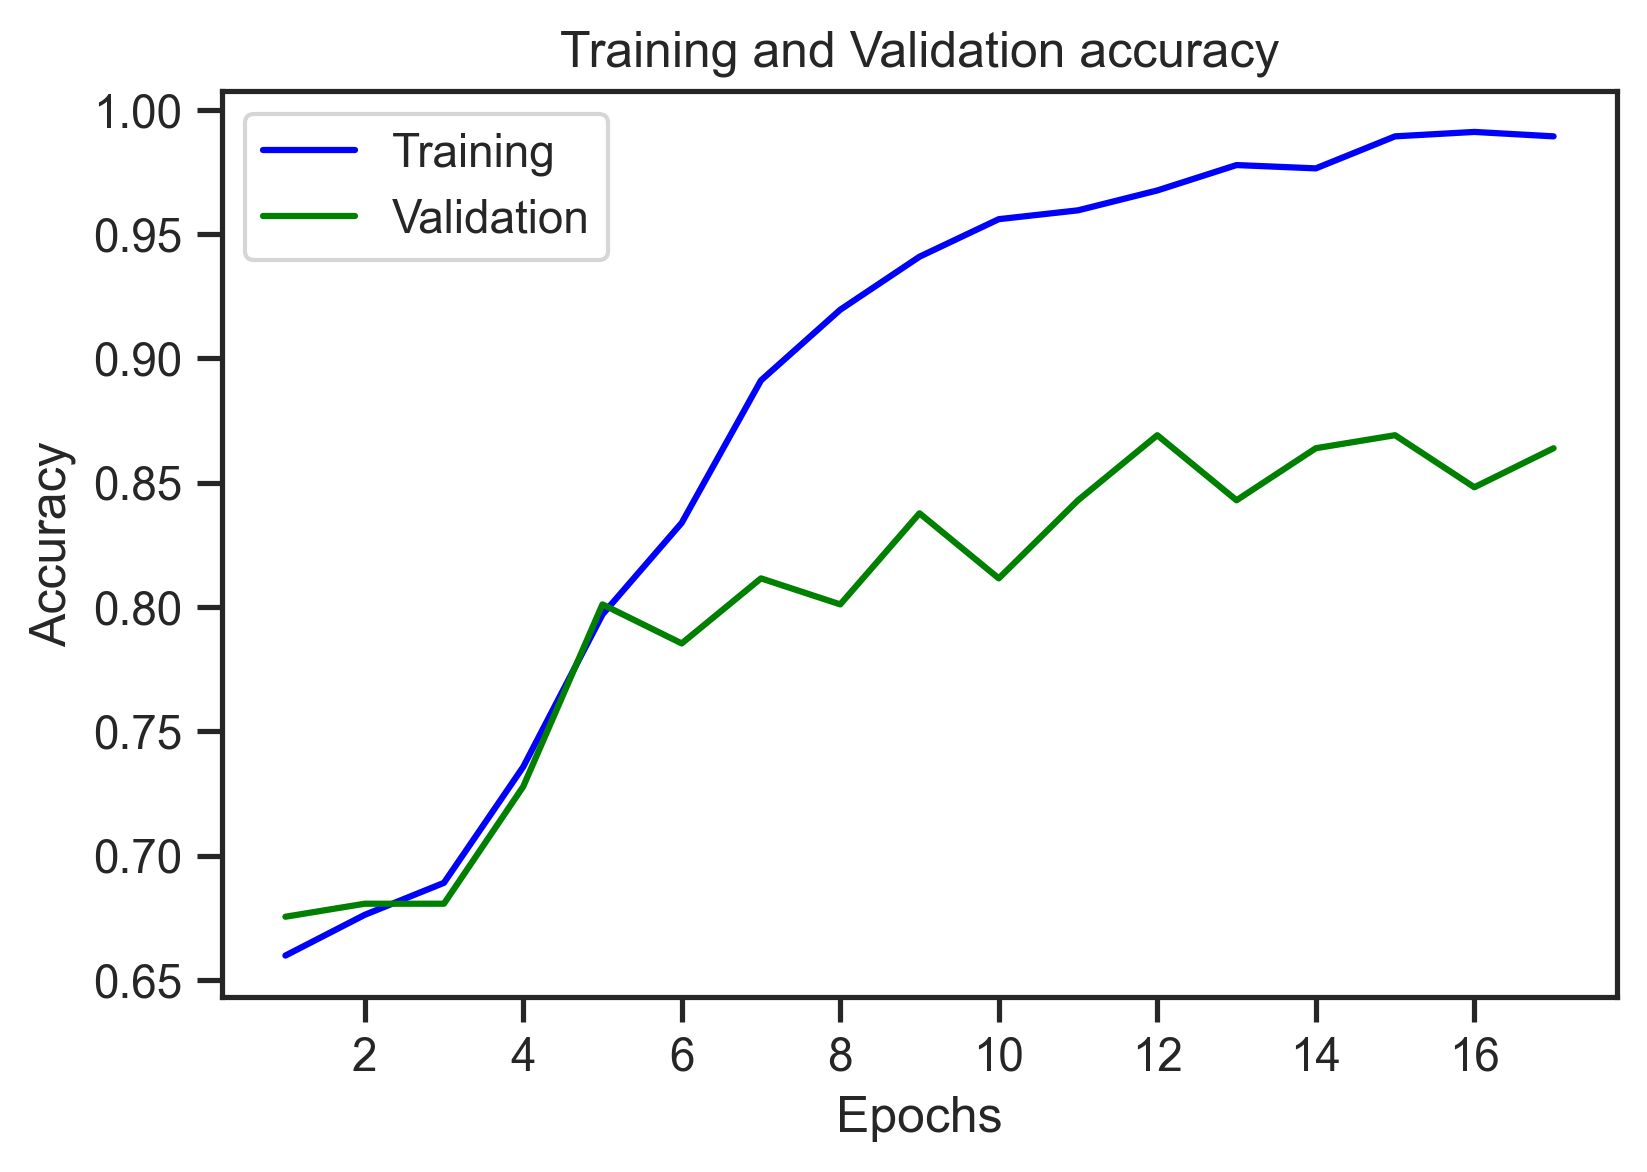

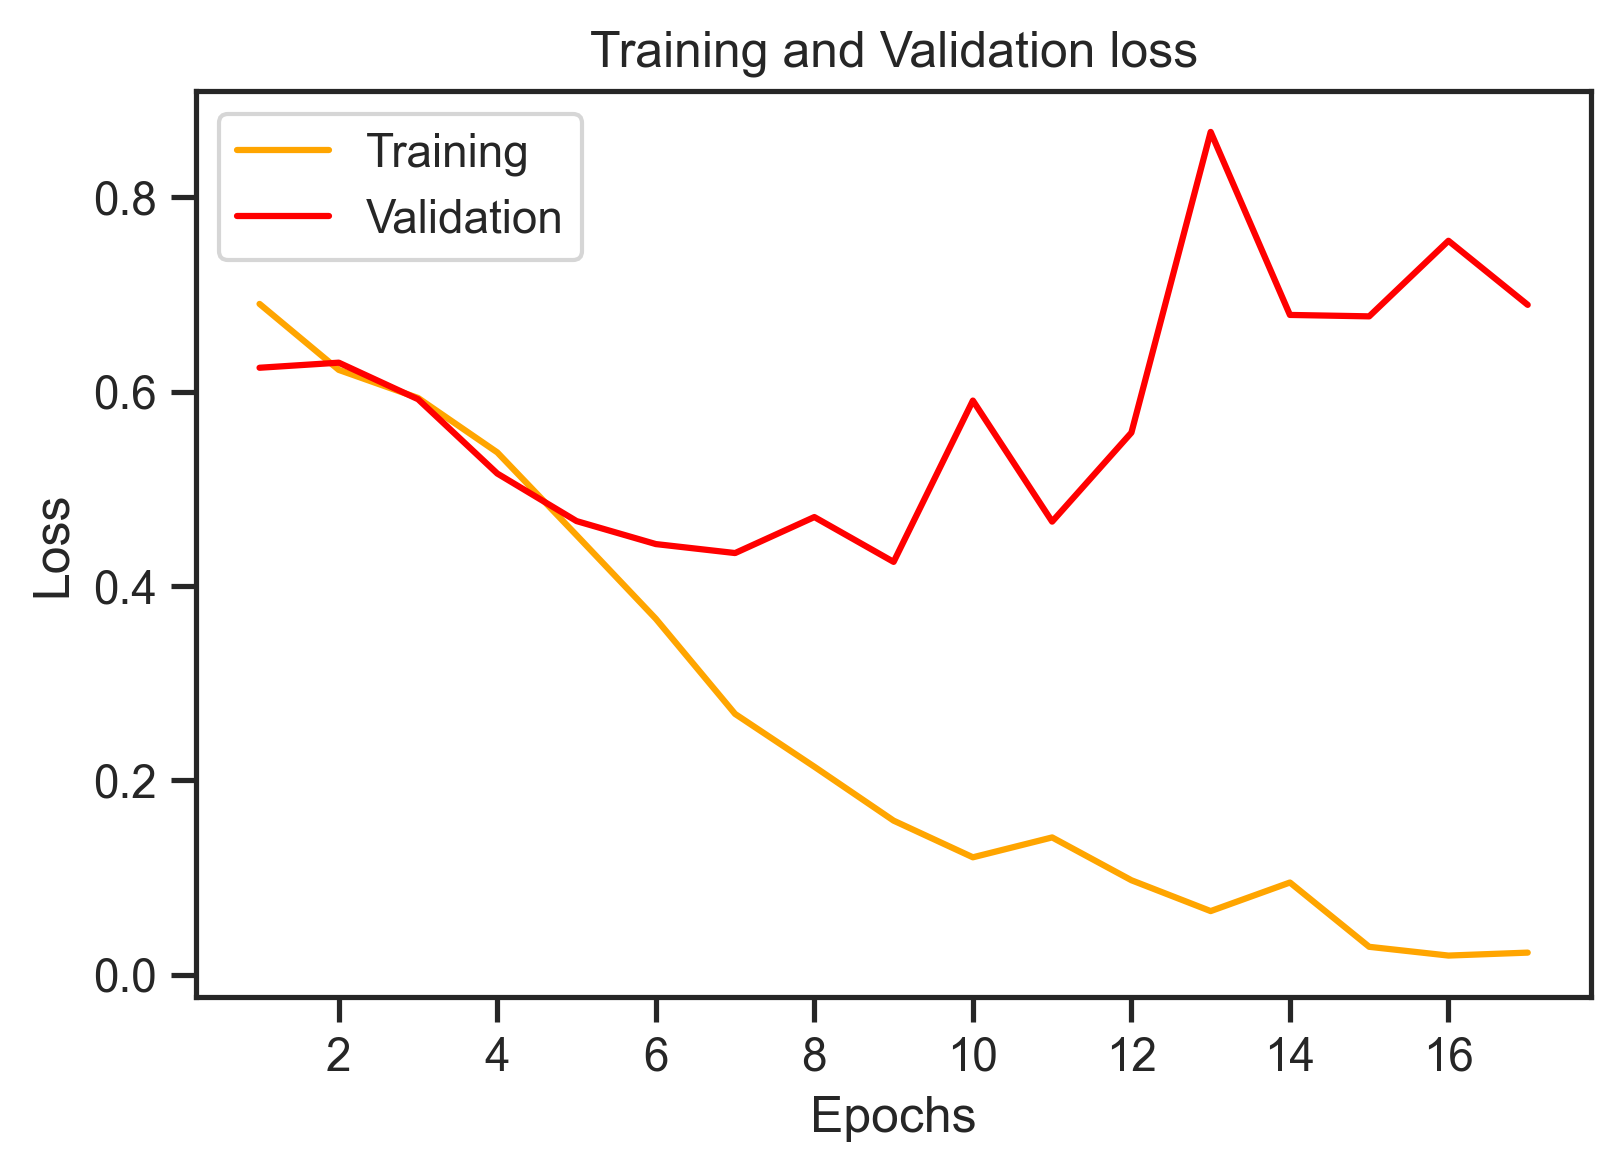

In [181]:
loss = model_2_5.history['loss']
val_loss = model_2_5.history['val_loss']
acc = model_2_5.history['accuracy']
val_acc = model_2_5.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 3 - Adjusted VGG16 from github (Maria)

In [55]:
# Αποτελέι συνέχεια του προηγούμενου μοντέλου link: (model 2)
# https://github.com/mohandandamudi/FaceMaskDetection/blob/master/Face%20Mask%20Detection.ipynb

* Creating Improved model
#####
We are going to use VGG16 model here

In [53]:
vgg16_model = tf.keras.applications.vgg16.VGG16()
# vgg16_model.summary() #lets look at summary.

* Couple of things that need to be changes.
1. We need a sequential model unlike VGG16
2. The last Dense layer in VGG16 has 1000 ouputs but we need only two

In [54]:
# So we will create a blank sequential model and then add layers from VGG16 except last one
vgg16_adj = tf.keras.models.Sequential()

for layer in vgg16_adj.layers[:-1]:
    vgg16_adj.add(layer)

vgg16_adj.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [55]:
# By Default the VGG16 layers are well trained for image classification so no need to update the weights at each layer.
for layer in vgg16_adj.layers:
    layer.trainable=False

In [56]:
# Adding dense layer with 2 outputs
vgg16_adj.add(tf.keras.layers.Dense(2, activation='softmax'))

opt = optimizers.Adam(learning_rate=learning_Rate)
vgg16_adj.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 'Recall', 'Precision', 'AUC']) 

#Lets look at the final model summary.
vgg16_adj.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [57]:
model_3 = vgg16_adj.fit(
                    x = X_train,
                    y = y_train,
                    epochs = num_Epochs, #>=30,
                    steps_per_epoch = steps_per_epoch, 
                    batch_size = batch_Size, #batch_size = 32 or 16
                    verbose = 1,
                    validation_data = (X_val, y_val),
                    callbacks = [early_stopping, lrr]
                    )

Epoch 1/50
71/71 [==============================] - 198s 3s/step - loss: 0.6857 - accuracy: 0.6360 - recall: 0.6360 - precision: 0.6360 - auc: 0.6807 - val_loss: 0.5943 - val_accuracy: 0.6963 - val_recall: 0.6963 - val_precision: 0.6963 - val_auc: 0.7503 - lr: 0.0010
Epoch 2/50
71/71 [==============================] - 197s 3s/step - loss: 0.5952 - accuracy: 0.6775 - recall: 0.6775 - precision: 0.6775 - auc: 0.7469 - val_loss: 0.5892 - val_accuracy: 0.6963 - val_recall: 0.6963 - val_precision: 0.6963 - val_auc: 0.7634 - lr: 0.0010
Epoch 3/50
71/71 [==============================] - 202s 3s/step - loss: 0.5610 - accuracy: 0.7068 - recall: 0.7068 - precision: 0.7068 - auc: 0.7793 - val_loss: 0.5684 - val_accuracy: 0.7382 - val_recall: 0.7382 - val_precision: 0.7382 - val_auc: 0.7808 - lr: 0.0010
Epoch 4/50
71/71 [==============================] - 201s 3s/step - loss: 0.5525 - accuracy: 0.7175 - recall: 0.7175 - precision: 0.7175 - auc: 0.7882 - val_loss: 0.5700 - val_accuracy: 0.7225 - va

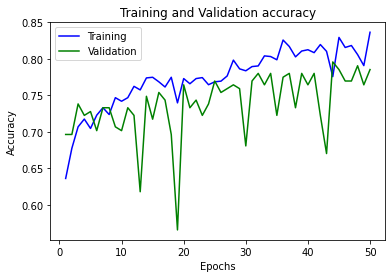

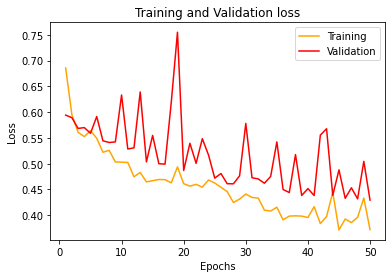

In [58]:
loss = model_3.history['loss']
val_loss = model_3.history['val_loss']
acc = model_3.history['accuracy']
val_acc = model_3.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 3.5 - Original VGG16 (Maria)

In [51]:
# https://github.com/hrithikppawar/Face-Mask-Detection-Using-VGG16/blob/main/Face_Mask_Detection_VGG16.ipynb

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3,), activation = 'relu', padding = 'same', input_shape=(224, 224, 3)),)
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

In [ ]:
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

model.summary()

In [ ]:
# Compiling the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    #metrics="accuracy"
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
data_size = len(X_TRAIN) 
steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

In [ ]:
# Fit the model on train data
model_history = model.fit(
    x=X_TRAIN,
    y=Y_TRAIN,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    #verbose=2, #will just mention the number of epoch like this 
    # verbose=0 will show you nothing (silent)
    validation_data=(X_TEST,Y_TEST),
    # validation_steps=val_steps,
    callbacks=[early_stopping, lrr]
)

### Model 4 - MobileNet2 (Alamanis)

In [223]:
data_mn2, input_shape_mn2 = reshape_img_input(x=full_imgs_array,
                                         img_rows=224, 
                                         img_cols=224,
                                         normalize=False)

Original shape of nd-array: (3044, 224, 224, 3)


In [224]:
# split into train test sets
X_train_mn, X_test_1_mn, y_train_mn, y_test_1_mn = train_test_split(data_mn2, full_imgs_labels,
                                                    stratify=full_imgs_labels, 
                                                    test_size=0.25, random_state=5)

X_test_mn, X_val_mn, y_test_mn, y_val_mn = train_test_split(X_test_1_mn, y_test_1_mn,
                                                    stratify=y_test_1, 
                                                    test_size=0.25, random_state=5)

In [227]:
train_dt = tf.data.Dataset.from_tensor_slices((X_train_mn, y_train_mn))
train_dt = train_dt.batch(batch_Size, drop_remainder=True)
train_dt

<BatchDataset element_spec=(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 2), dtype=tf.float32, name=None))>

In [228]:
valid_dt = tf.data.Dataset.from_tensor_slices((X_val_mn, y_val_mn))
valid_dt = valid_dt.batch(batch_Size, drop_remainder=True)
valid_dt

<BatchDataset element_spec=(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 2), dtype=tf.float32, name=None))>

In [229]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [246]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (224, 224) + (3,)
mobile_net = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [247]:
image_batch, label_batch = next(iter(valid_dt))
feature_batch = mobile_net(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [248]:
mobile_net.trainable = False

In [249]:
mobile_net.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [253]:
mobile_net_2 = Sequential()
mobile_net_2.add(mobile_net)
mobile_net_2.add(Dense(2, activation="softmax"))

In [234]:
prediction_layer = tf.keras.layers.Dense(2)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [235]:
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = mobile_net(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
mobile_net_2 = tf.keras.Model(inputs, outputs)

In [254]:
mobile_net_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_Rate),
              loss = "categorical_crossentropy",
              metrics = ['accuracy', 'Recall', 'Precision', 'AUC'])

In [237]:
tf.data.experimental.cardinality(dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=95>

In [105]:
train_size = int(0.8 * 95)
val_size = int(0.1 * 95)
    
train_ds = dataset.take(train_size)    
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size).skip(val_size)

In [257]:
model_4 = mobile_net_2.fit(
                    x = X_train,
                    y = y_train,
                    epochs = num_Epochs,
                    steps_per_epoch = steps_per_Epoch, 
                    verbose = 1,
                    #validation_data = valid_dt,
                    validation_data = (X_val, y_val),
                    callbacks = [early_stopping, lrr]
                    )

Epoch 1/50


ValueError: in user code:

    File "c:\Users\kwnst\anaconda3\envs\conda_env\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kwnst\anaconda3\envs\conda_env\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kwnst\anaconda3\envs\conda_env\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kwnst\anaconda3\envs\conda_env\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\kwnst\anaconda3\envs\conda_env\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "c:\Users\kwnst\anaconda3\envs\conda_env\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\kwnst\anaconda3\envs\conda_env\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\kwnst\anaconda3\envs\conda_env\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\kwnst\anaconda3\envs\conda_env\lib\site-packages\keras\losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\kwnst\anaconda3\envs\conda_env\lib\site-packages\keras\backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 2) and (None, 7, 7, 2) are incompatible


## Models Comparison 


* Functions for plot loss and accuracy and evaluation

In [ ]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    
    """Evaluation function
    Prints Classification reports and confusion matrix
    """
    cm = confusion_matrix(y, y_hat)
#     precision = precision_score(y, y_hat)
#     recall = recall_score(y, y_hat)
#     accuracy = accuracy_score(y,y_hat)
#     f1 = f1_score(y,y_hat)
#     report = classification_report(y,y_hat)
#     print(report)
#     print('Recall: ', recall)
#     print('Accuracy: ', accuracy)
#     print('Precision: ', precision)
#     print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

In [ ]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')

In [59]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, log_loss
from sklearn.datasets import make_classification
from sklearn import model_selection

* Precision: The model precision score measures the proportion of positively predicted labels that are actually correct. Precision is also known as the positive predictive value. Precision Score = TP / (FP + TP)
* Accuracy: Tells us how often we can expect our machine learning model will correctly predict an outcome out of the total number of times it made predictions.  Accuracy Score = (TP + TN)/ (TP + FN + TN + FP)
* Recall score is used to measure the model performance in terms of measuring the count of true positives in a correct manner out of all the actual positive values.
* F1-score is harmonic mean of precision and recall score and is used as a metrics in the scenarios where choosing either of precision or recall score can result in compromise in terms of model giving high false positives and false negatives respectively. 
    F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)



In [182]:
classifiers = [
    model_few_Layers,
    model_complex,
    model_complex_adj,
    improved_model
    ]
name_of_model = [
    "model_few_Layers",
    "model_complex",
    "model_complex_adj",
    "improved_model"
    ]
    

In [183]:
# Logging for Visual Comparison
log_cols = ["Classifier", "Accuracy", "Precision", "Recall", "F1", "AUC"]

log = pd.DataFrame(columns=log_cols)
i = 0

for clf in classifiers:

    name=name_of_model[i]
    i+=1    

    # #Fit the model
    # clf.fit(
    #         x=X_train,
    #         y=y_train,
    #         epochs=50, #>=30,
    #         steps_per_epoch=steps_per_epoch , 
    #         batch_size=32, #batch_size = 32 or 16
    #         verbose=1,
    #         validation_data=(X_val,y_val),
    #         callbacks=[early_stopping, lrr]
    #         )

    # calculate y_pred
    y_true = np.argmax(y_test, axis = 1)[:]
    pred = clf.predict(X_test, verbose = 0) # Predict prob and get Class Indices
    y_pred= np.argmax(pred, axis = 1)[:]

    # calcualte accuracy
    acc = accuracy_score(y_pred[:], y_true[:])
    
    # calcualte precision	
    pre = precision_score(y_pred[:], y_true[:])

    # calcualte Recall	
    rec = recall_score(y_pred[:], y_true[:])

    # calcualte F1-score
    f1 = f1_score(y_pred[:], y_true[:])

    ## calculate scores
    auc = roc_auc_score(y_true, y_pred)
    
    #entry them in a dataframe for visualization
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100, f1*100, auc*100]], columns=log_cols)
    #log = log.append(log_entry)
    log = pd.concat([log, log_entry], axis = 0)
    
    # Print the results
    # print("="*30)   
    # print('**** Results ' + name + '****')
    # print("Accuracy: {:.4%}".format(acc))
    # print("Precision: {:.4%}".format(pre) )
    # print("Recall: {:.4%}".format(rec) )
    # print("F1-score: {:.4%}".format(f1) )
    # print( name + ": ROC AUC: {:.4%}".format(auc))

# print("="*15 + " End " + "="*15)

In [184]:
log

,Classifier,Accuracy,Precision,Recall,F1,AUC
0,model_few_Layers,79.473684,90.104167,81.411765,85.537701,73.815524
0,model_complex,81.578947,95.052083,80.931264,87.425150,74.407762
0,model_complex_adj,86.315789,92.708333,87.684729,90.126582,82.913306
0,improved_model,77.017544,88.541667,79.625293,83.847102,70.883737


* Plot

In [113]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

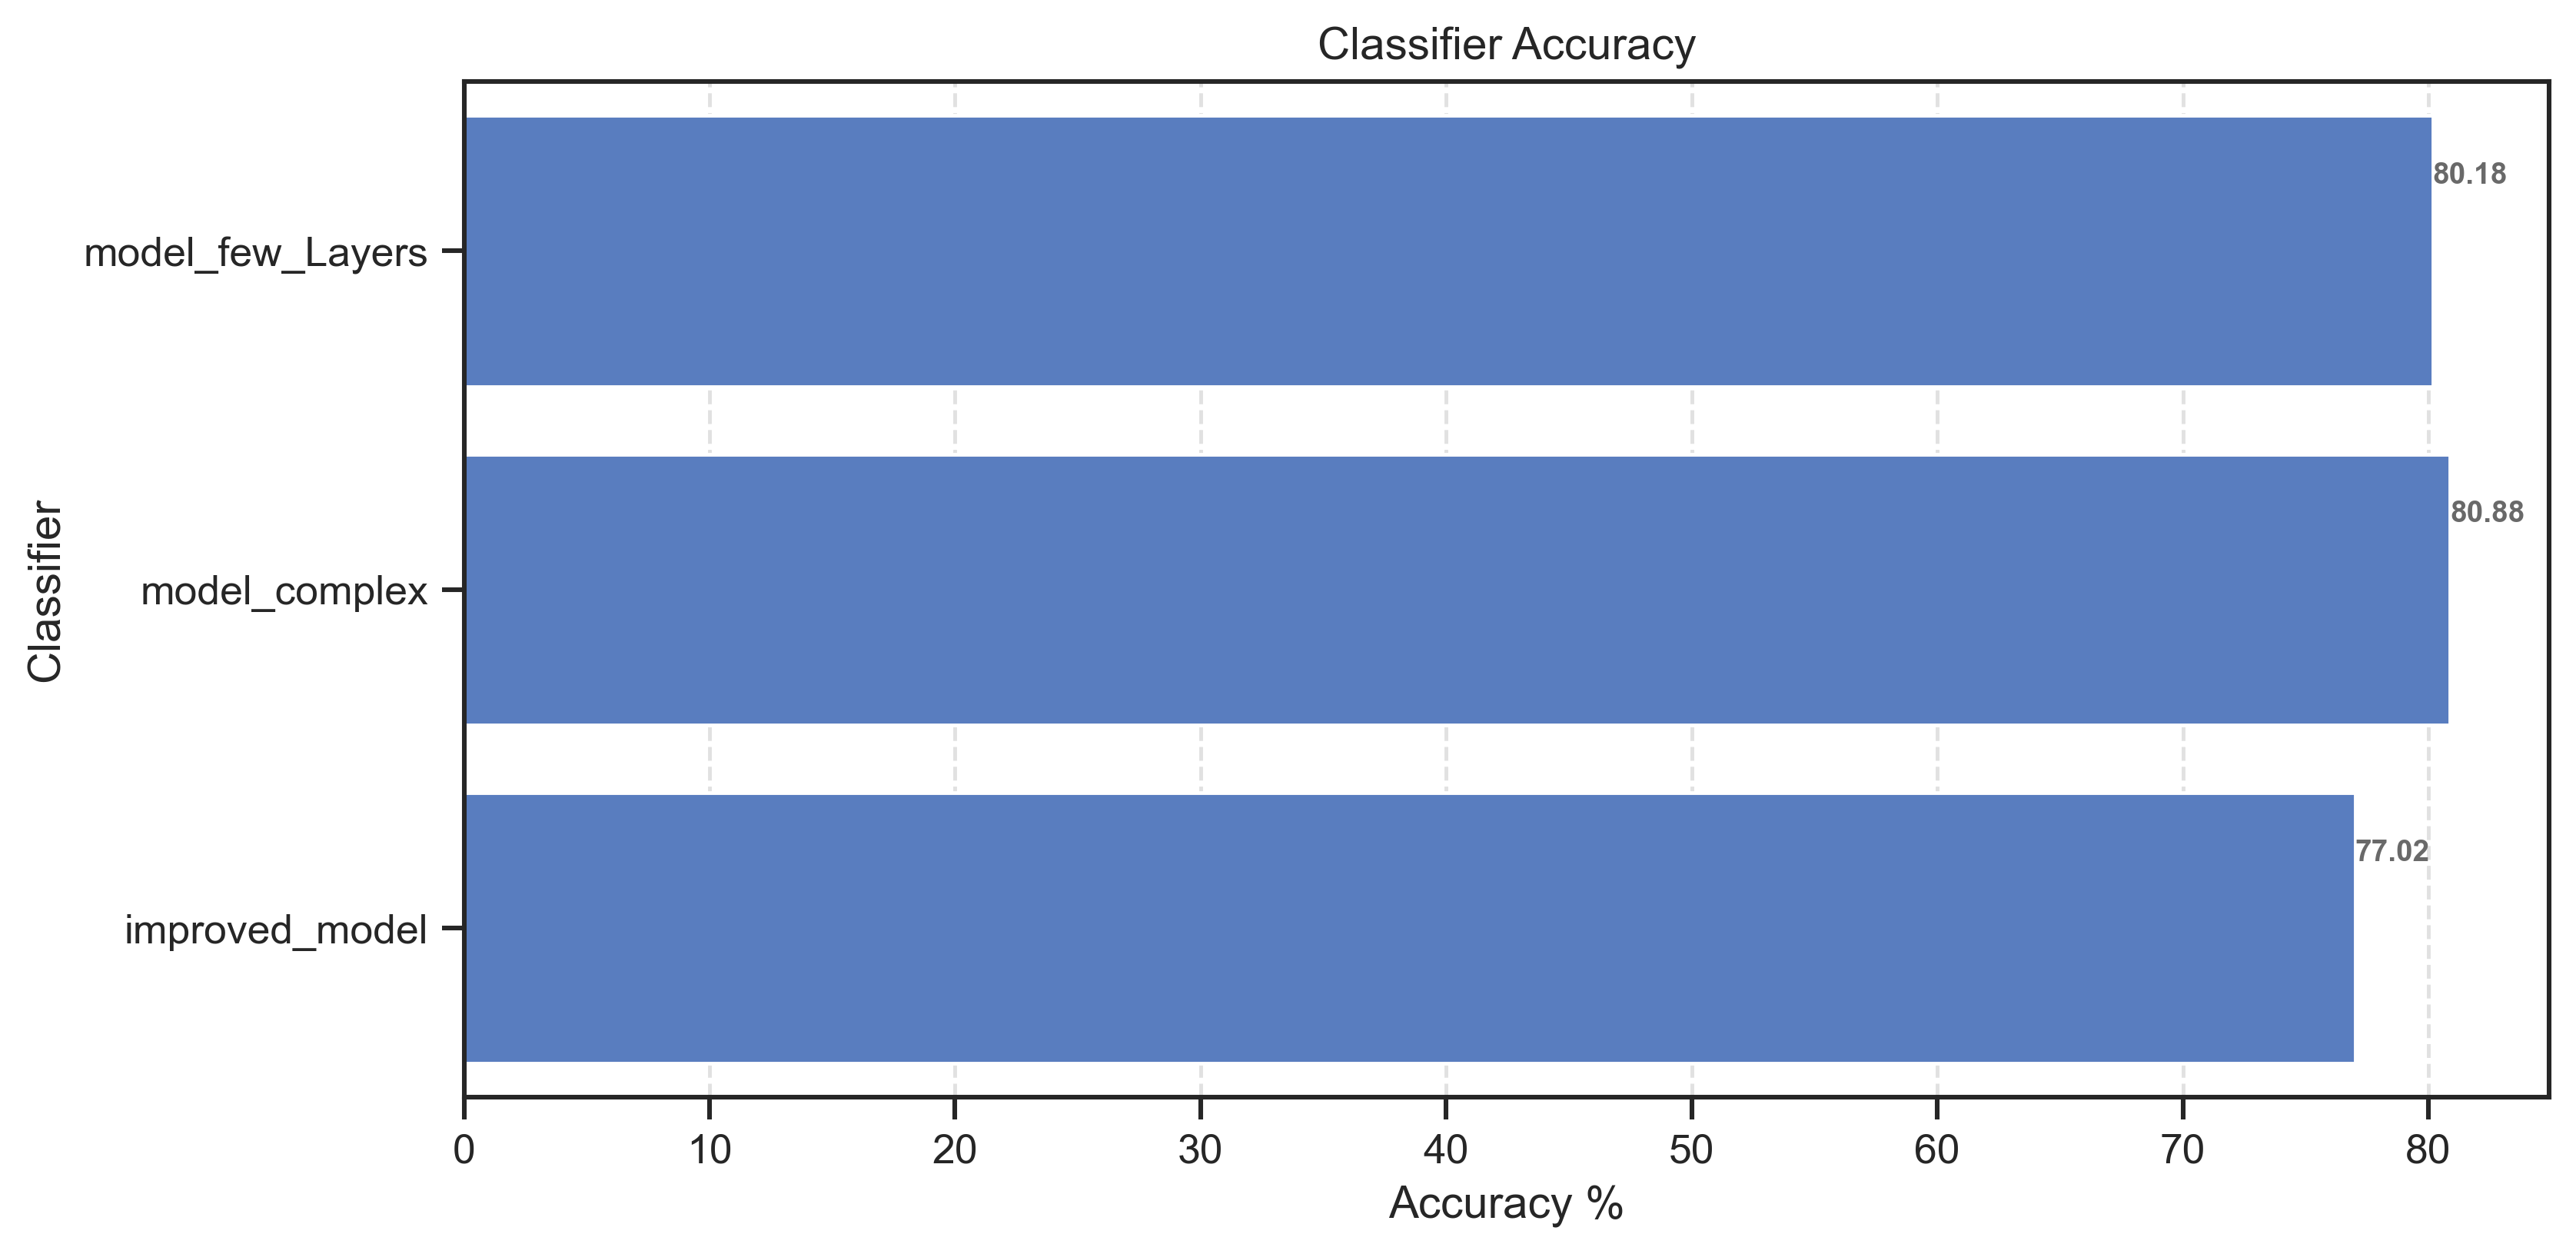

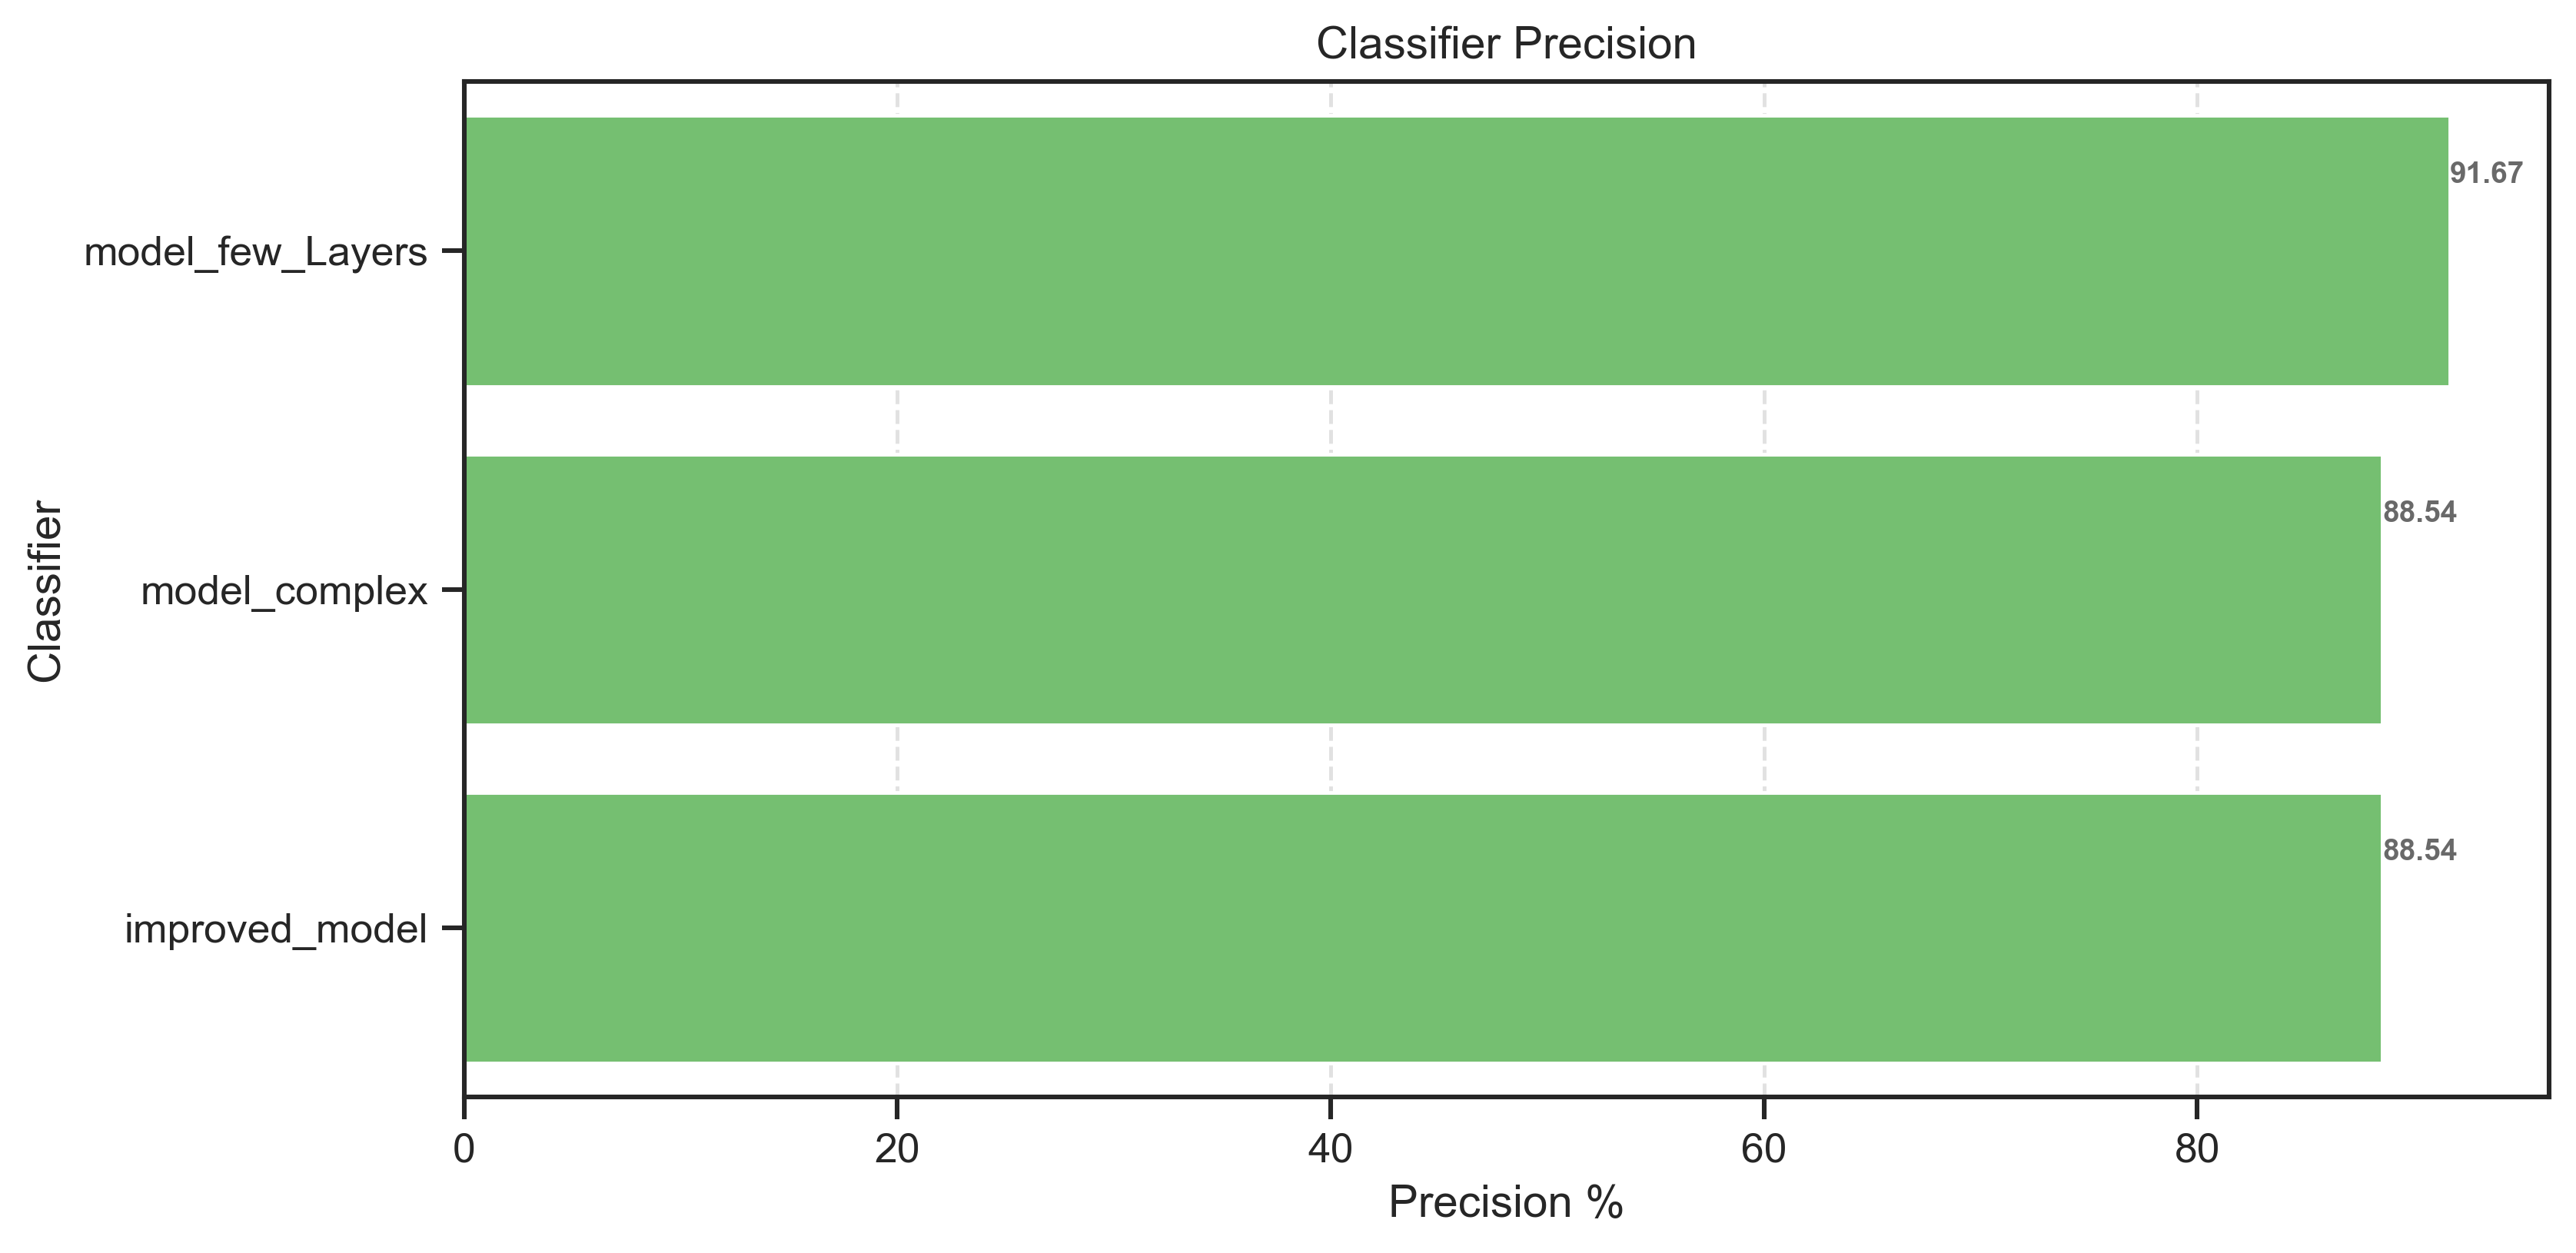

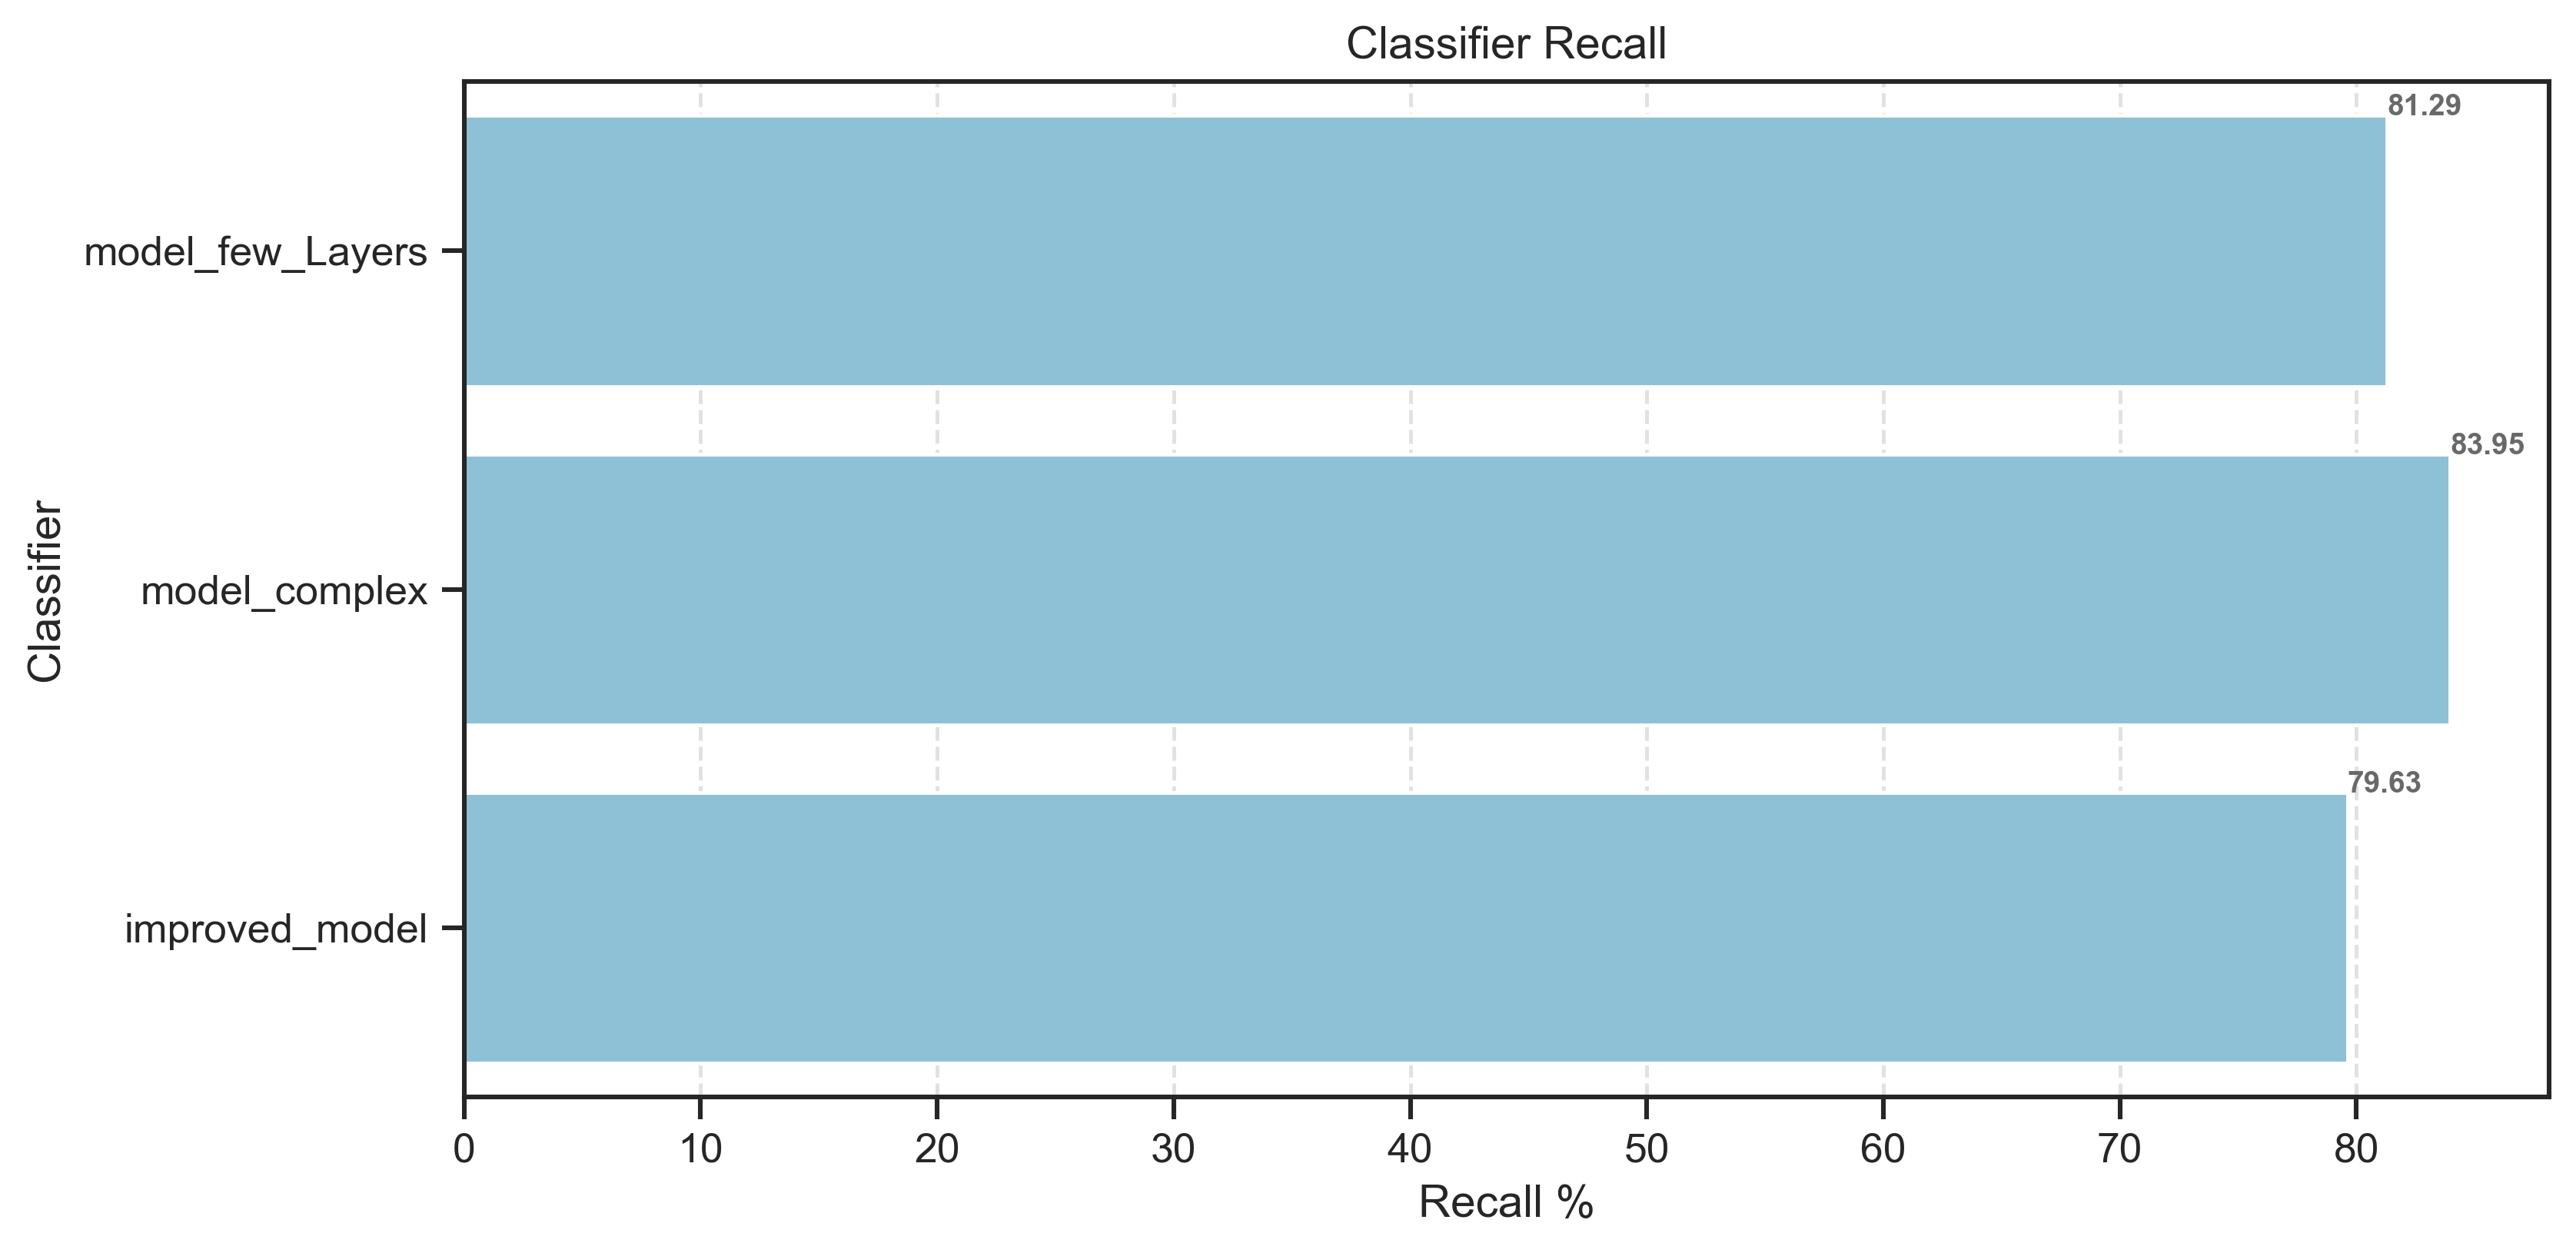

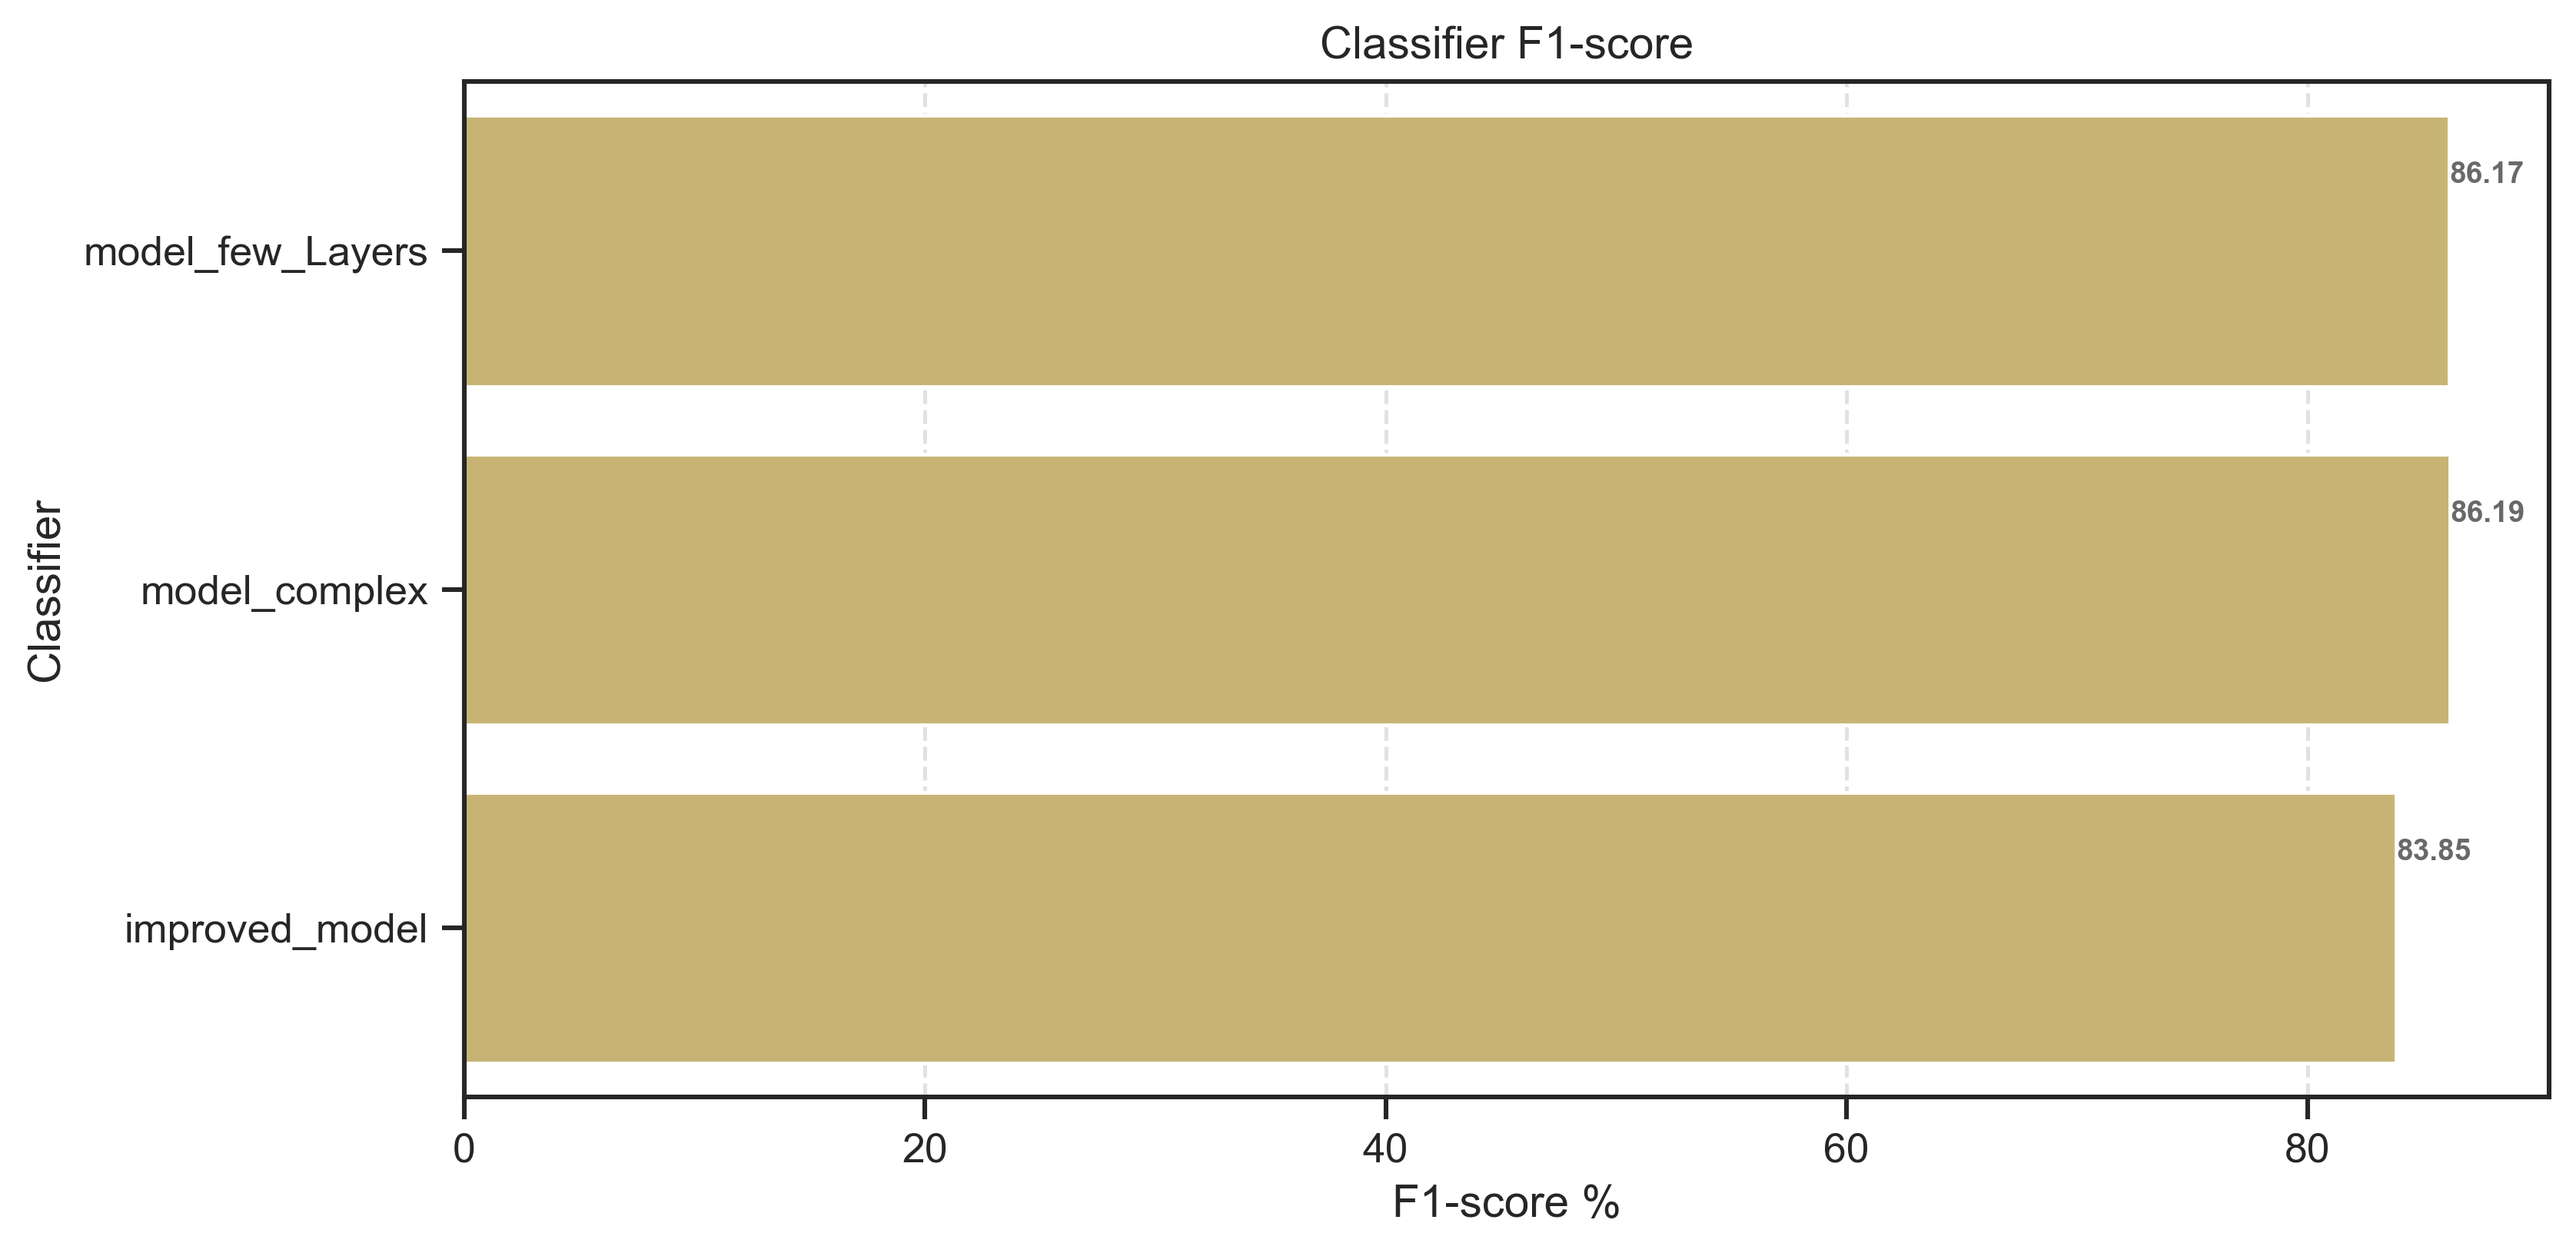

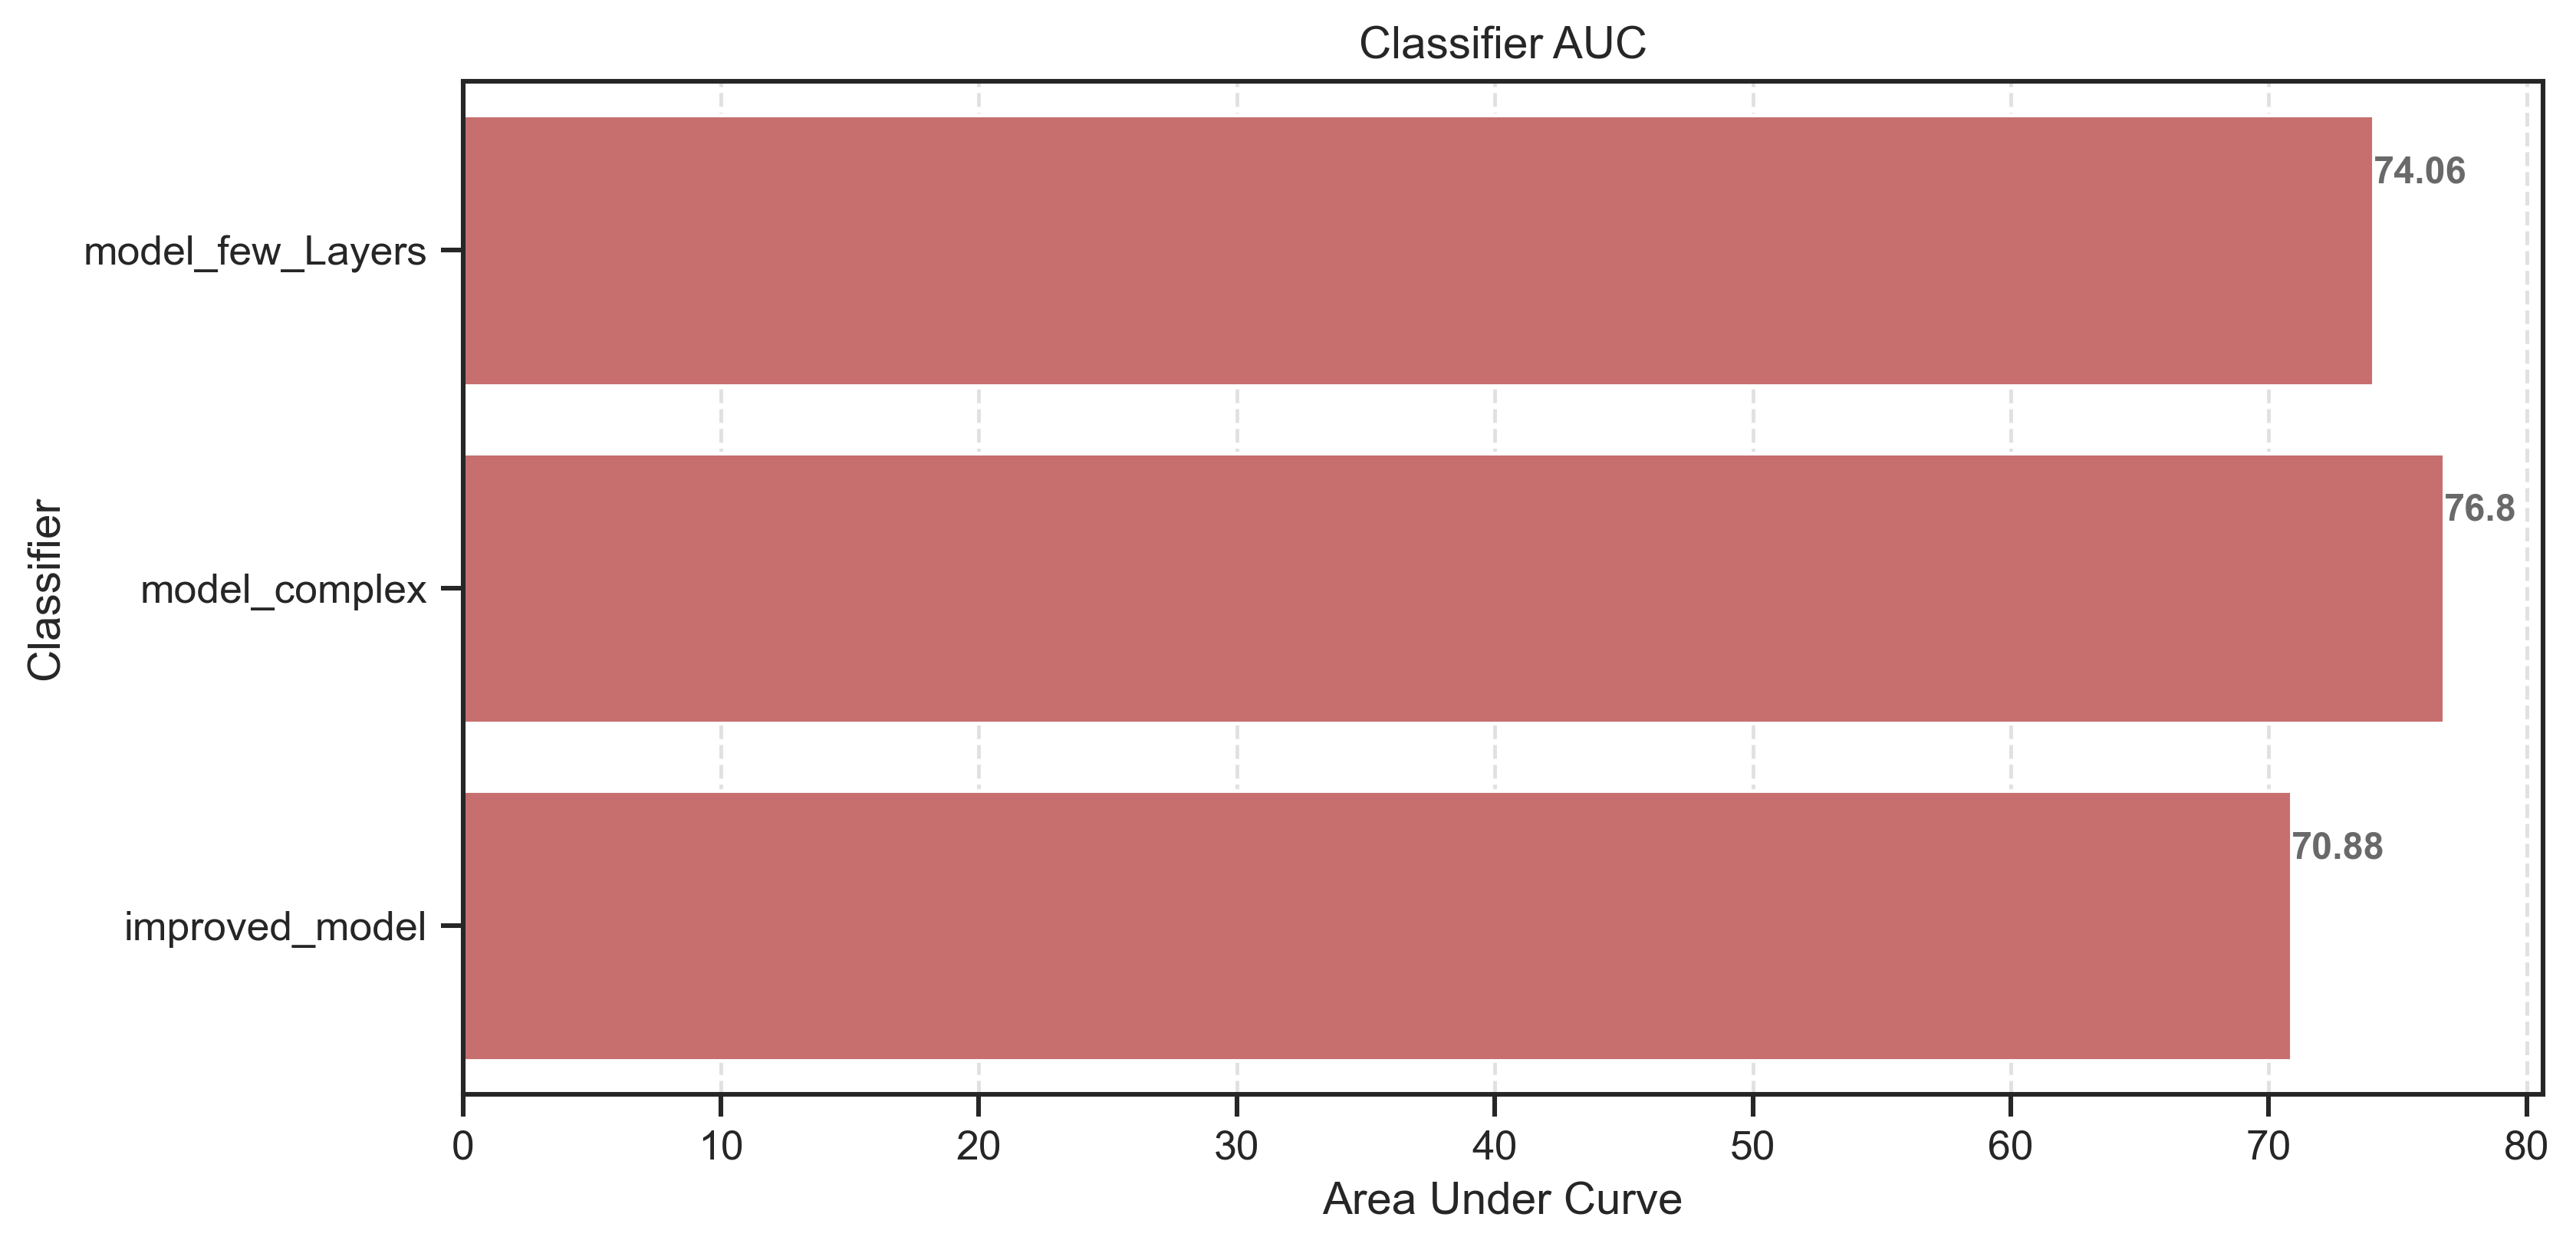

In [112]:
## Accuracy
# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.2,
             str(round((i.get_width()), 2)),
             fontsize = 8, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

## Precision

# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Classifier', data=log, color="g")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.2,
             str(round((i.get_width()), 2)),
             fontsize = 8, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('Precision %')
plt.title('Classifier Precision')
plt.show()

## Recall

# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=log, color='c')

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y(),
             str(round((i.get_width()), 2)),
             fontsize = 8, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('Recall %')
plt.title('Classifier Recall')
plt.show()

## F1

# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='F1', y='Classifier', data=log, color="y")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.2,
             str(round((i.get_width()), 2)),
             fontsize = 8, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('F1-score %')
plt.title('Classifier F1-score')
plt.show()

## AUC
# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='AUC', y='Classifier', data=log, color="r")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.2,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('Area Under Curve')
plt.title('Classifier AUC')
plt.show()

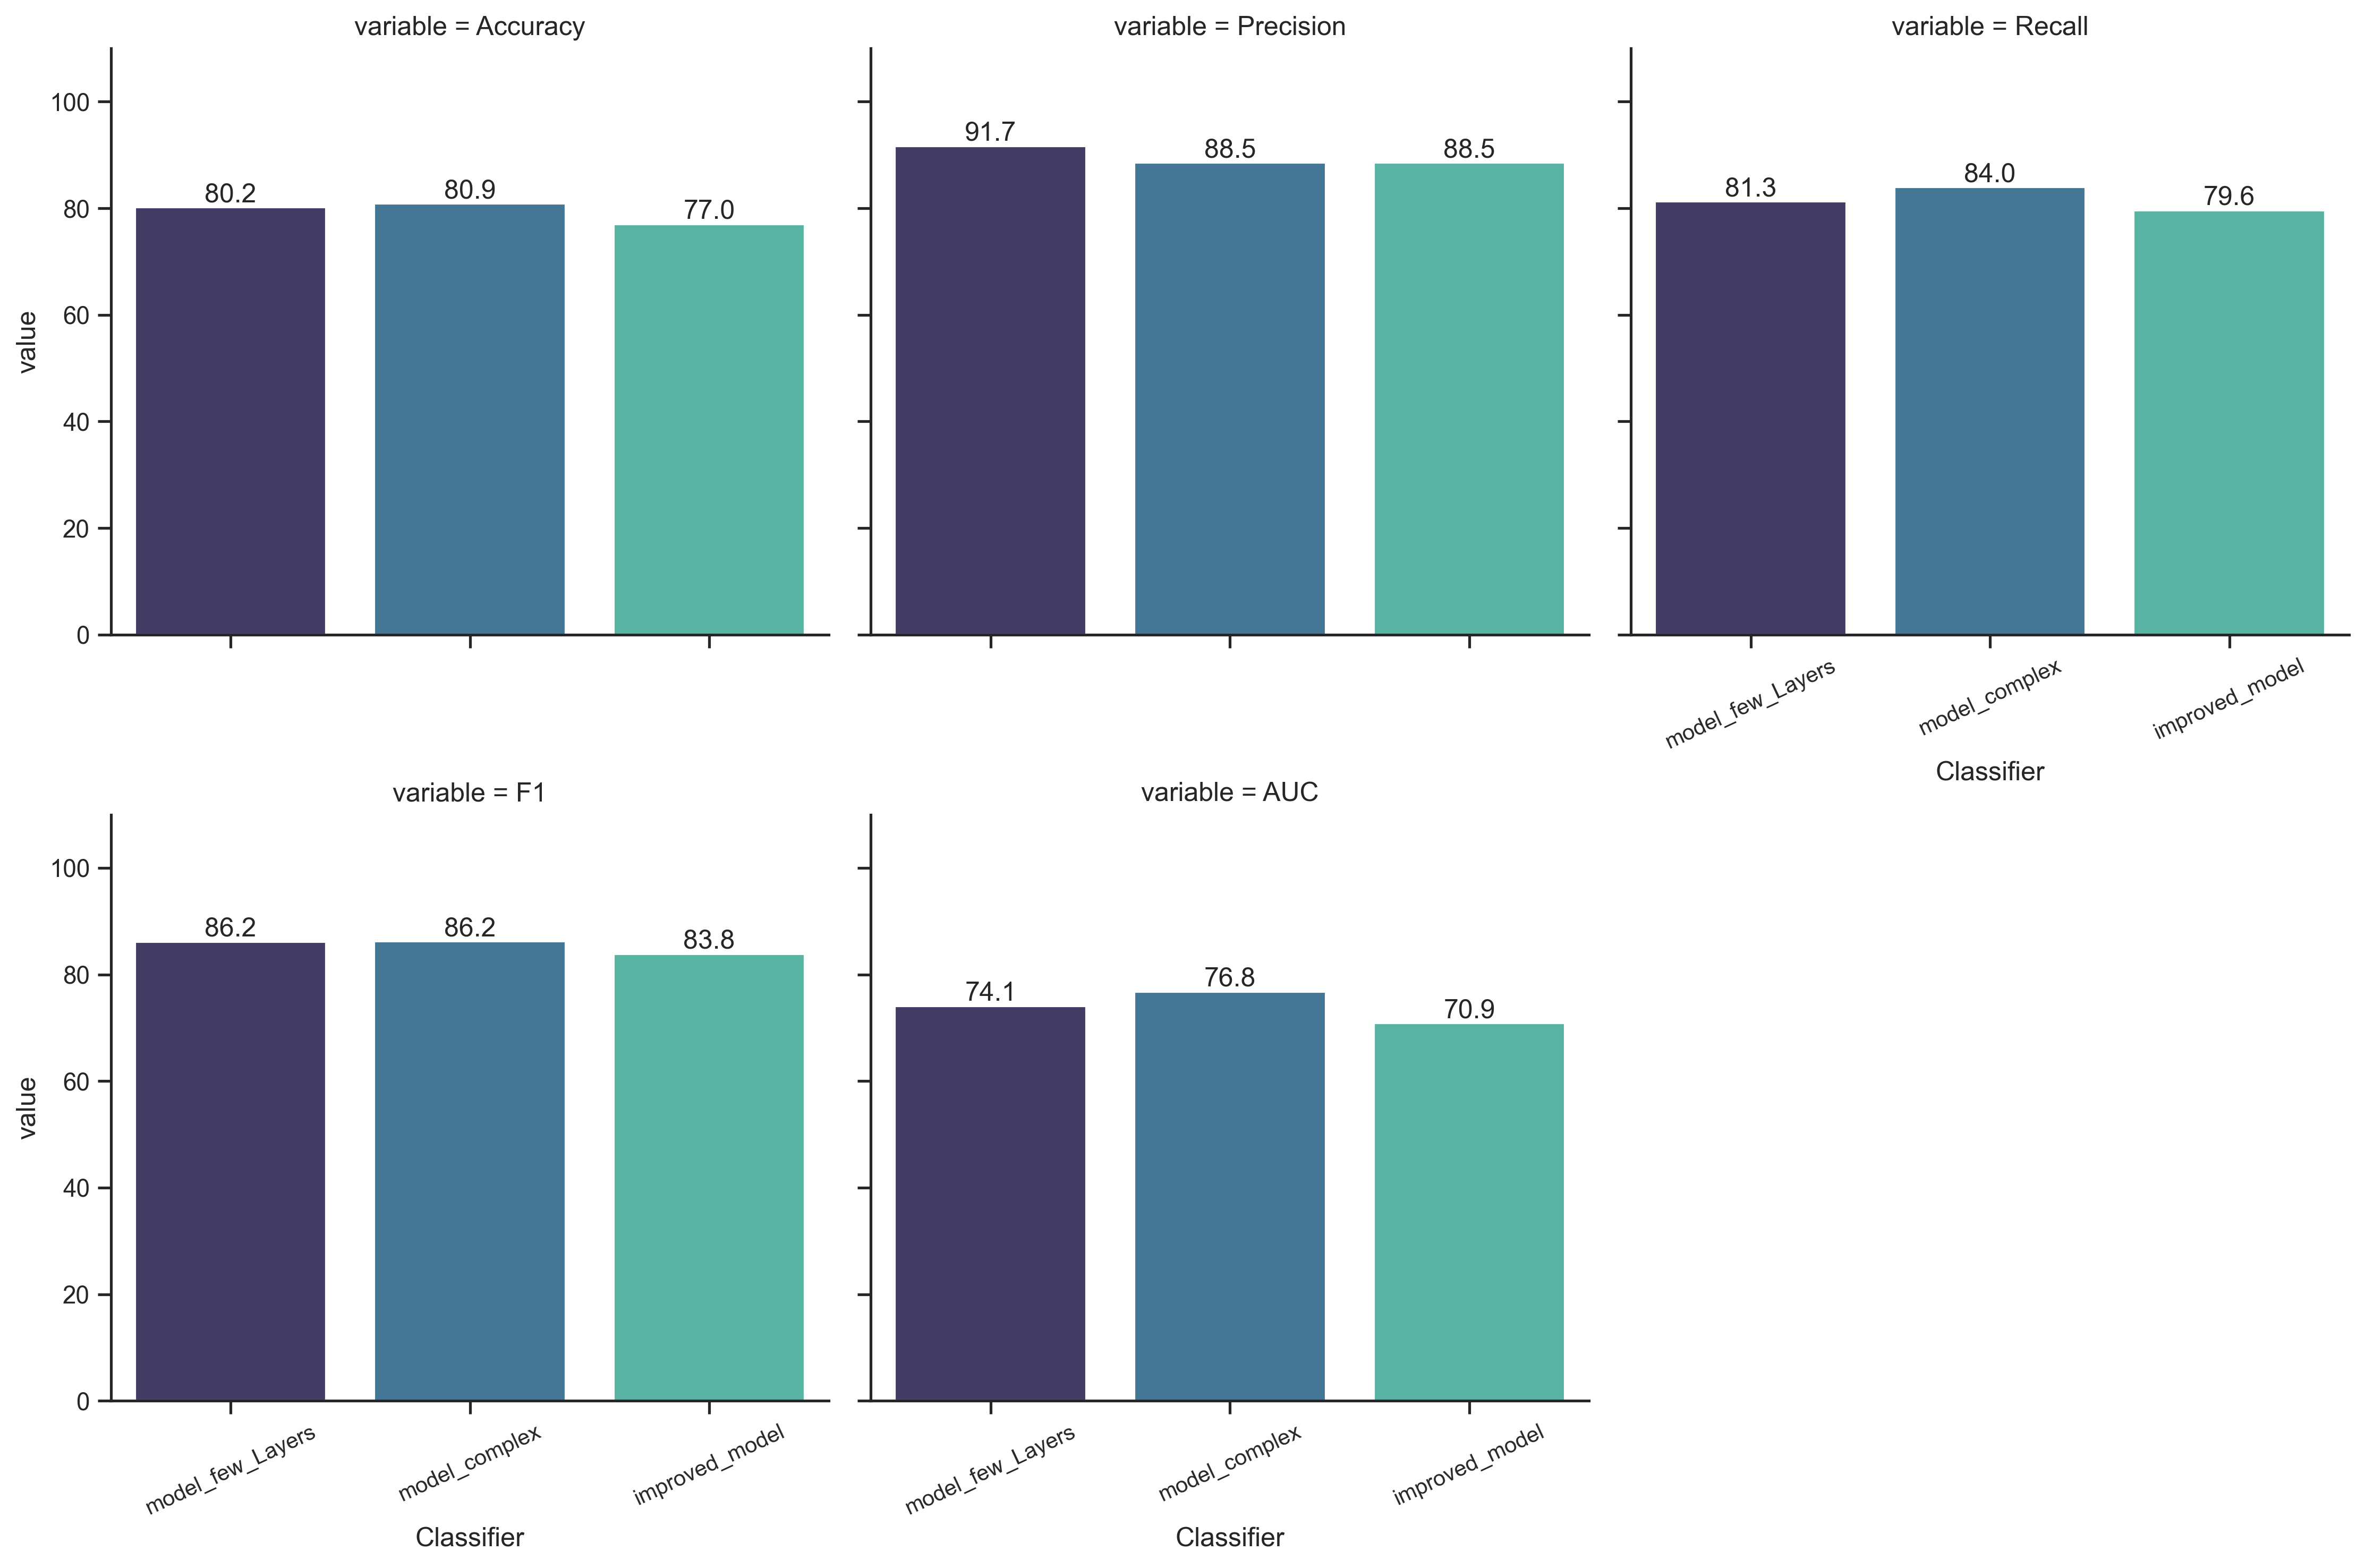

In [117]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

df2 = pd.melt(log, value_vars=[ "Accuracy", "Precision", "Recall", "F1", "AUC"], id_vars="Classifier")

#sns.set(style="ticks")

g = sns.catplot(data=df2,
                   kind="bar",
                   col="variable", # we have 1 plot per variable, forming 1 line and 5 columns (5 different variables)
                   x="Classifier", # in each plot the x-axis will be the name
                   y="value", # the height of the bar
                   col_wrap=3,# we actually want your line of plots to contain 3 plots maximum 
                   palette="mako", #Set2,Paired
                  )

# adding labels to bars
for ax in g.axes.ravel():
    for c in ax.containers:
        labels = [f'{(v.get_height()):.1f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)
 
g.set_xticklabels(fontsize=10, rotation=25) # rotate the labels so they don't overlap
plt.tight_layout() # fit everything into the figure


* Plot Area Under Curve

C:\Users\kwnst\AppData\Local\Temp\ipykernel_12804\588644489.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = True, color ='dimgrey',


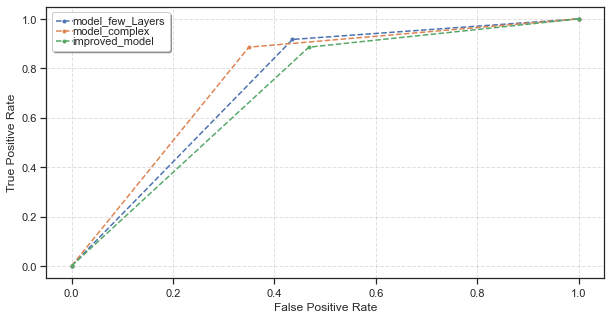

In [85]:
i=0
labels=[]

# Figure Size
plt.subplots(figsize =(10, 5))


# Add x, y gridlines
plt.grid(b = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

# Plot several different AUC
for clf in classifiers:

  name = name_of_model[i]
   
  i+=1    
 
  y_true = np.argmax(y_test, axis = 1)[:]

  pred = clf.predict(X_test,verbose = 0) # Predict prob and get Class Indices
  y_pred= np.argmax(pred, axis = 1)[:]

   # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_true, y_pred)

   # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, marker='.', linestyle='--', label=name)
  labels.append(name)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(labels, 
          columnspacing=1.0, 
          labelspacing=0.0,
          handletextpad=0.0, 
          handlelength=1.5,
          fancybox=True,
          shadow=True)
   
# show the plot
plt.show()

---------------------------------------------------------------------------------------------- END ----------------------------------------------------------------------------------------------